**Author: Autumn Salsberry**

Contact: <a href="https://www.linkedin.com/in/salsbeas/">linkedin.com/in/salsbeas</a>

BrainStation Capstone: Predicting Adoptability of Shelter Dogs

August 8, 2022

This notebook is for joining the relevant details from the three Austin, TX shelter data frames and cleaning the data for EDA in Tableau and modeling purposes. As noted in notebook 1, the breed and color of the animal from the intake and outcome datasets can be joined with the "all" dataset because this information is relevant to predicting if a dog will be adopted or not. After this join, there are a lot of categorical variables that will need to be converted to binaries or OneHotEncoded depending on the discoveries in basic EDA for each column type. 

# Table of Contents

* [Joining the Data Frames](#join)
* [Clean the Data](#clean)
    * [Date and Time Columns](#date)
    * [Breed Columns](#breed)
    * [Coat Color](#color)
    * [Age](#age)
    * [Fixed Status Columns](#fixed)
    * [Outcome (Adopted) Column](#adopt)
    * [Gender and Sex Columns](#sex)
    * [Intake Condition Columns](#intake)
    * [Split Date Columns](#split)
* [Rename The Columns](#rename) 
* [Download the Data Frames](#download)

In [1]:
#upload the basic packages for discovery and cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for sorting dummies
import re

# for datetimes
from datetime import timedelta

#ignore warnigns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#only working with the Austin, TX shelter data frames
all_info_df = pd.read_csv('Tabular Data/all_records.csv')
intakes = pd.read_csv('Tabular Data/Austin_Animal_Center_Intakes.csv')
outcomes = pd.read_csv('Tabular Data/Austin_Animal_Center_Outcomes.csv')

# Goals

* Join all three data frames on Animal ID
* Explore the data and determine the best way to clean the data to prepare for further EDA and modeling
* Export cleaned dataset for further EDA and modeling

# Joining the Data Frames
<a class="anchor" id="join"></a>

In this section I will join the tables using the common key "Animal ID) and assure there are no duplicates. 
   
The columns I will concatenate from `outcomes` to `all_info_df` are:
   * `Date of Birth`
   * `Breed`
   * `Color`
   
Before joining the tables considering these columns, I will first remove the rows representing animals that were rescued other than dogs. Then I will create new intake and outcome data frames with only the relevant columns as noted above. Thus, I will have fewer rows to join on and fewer columns to concatenate. This will save some time. 

In [3]:
#check to make sure my code for sorting out only dogs does what I want it to
all_info_df[all_info_df['Animal_Type_intake'] == 'Dog'].head()

,Unnamed: 0,Animal ID,Name_intake,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,IntakeCondition,Animal_Type_intake,Sex,...,beagle,terrier,boxer,poodle,rottweiler,dachshund,chihuahua,pit bull,DateTime_length,Days_length
1,1,A683644,*Zoey,2014-07-13 11:02:00,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Dog,Intact Female,...,0,0,0,0,0,0,0,0,115 days 23:04:00.000000000,12 weeks - 6 months
2,2,A676515,Rico,2014-04-11 08:45:00,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Dog,Intact Male,...,0,0,0,0,0,0,0,1,3 days 09:53:00.000000000,0-7 days
3,3,A742953,NaN,2017-01-31 13:30:00,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Dog,Intact Male,...,0,0,0,0,0,0,0,0,4 days 00:47:00.000000000,0-7 days
11,11,A692161,George,2014-11-15 15:18:00,11/15/2014 03:18:00 PM,Avenue G/42Nd in Austin (TX),Owner Surrender,Normal,Dog,Intact Male,...,0,0,0,0,0,0,0,1,6 days 03:37:00.000000000,0-7 days
14,14,A720597,*Franklin,2016-02-12 14:35:00,02/12/2016 02:35:00 PM,8413 Danville Dr in Austin (TX),Stray,Injured,Dog,Intact Male,...,0,0,0,0,0,0,0,1,7 days 01:45:00.000000000,1-3 weeks


In [4]:
#make sure no other animals made the cut
all_info_df[all_info_df['Animal_Type_intake'] == 'Dog']['Animal_Type_intake'].unique()

array(['Dog'], dtype=object)

In [5]:
#create a new df with only dogs and reset the index
dog_all_info_df = all_info_df[all_info_df['Animal_Type_intake'] == 'Dog']
dog_all_info_df = dog_all_info_df.append(dog_all_info_df, ignore_index = True)

# drop the 'Animal_Type_intake' column since this tells us the animal is a dog and we already know this
dog_all_info_df.drop(['Unnamed: 0', 'Animal_Type_intake'], axis=1, inplace=True)

#Take a look to make sure the df looks how I expect it to
dog_all_info_df.head()

,Animal ID,Name_intake,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,IntakeCondition,Sex,Age,Breed_intake,...,beagle,terrier,boxer,poodle,rottweiler,dachshund,chihuahua,pit bull,DateTime_length,Days_length
0,A683644,*Zoey,2014-07-13 11:02:00,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Intact Female,4 weeks,Border Collie Mix,...,0,0,0,0,0,0,0,0,115 days 23:04:00.000000000,12 weeks - 6 months
1,A676515,Rico,2014-04-11 08:45:00,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,2 months,Pit Bull Mix,...,0,0,0,0,0,0,0,1,3 days 09:53:00.000000000,0-7 days
2,A742953,NaN,2017-01-31 13:30:00,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,2 years,Saluki,...,0,0,0,0,0,0,0,0,4 days 00:47:00.000000000,0-7 days
3,A692161,George,2014-11-15 15:18:00,11/15/2014 03:18:00 PM,Avenue G/42Nd in Austin (TX),Owner Surrender,Normal,Intact Male,5 months,Pit Bull Mix,...,0,0,0,0,0,0,0,1,6 days 03:37:00.000000000,0-7 days
4,A720597,*Franklin,2016-02-12 14:35:00,02/12/2016 02:35:00 PM,8413 Danville Dr in Austin (TX),Stray,Injured,Intact Male,2 years,Pit Bull Mix,...,0,0,0,0,0,0,0,1,7 days 01:45:00.000000000,1-3 weeks


In [6]:
#Compare these columns with the intake columns to confirm which we need to concatenate
dog_all_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96194 entries, 0 to 96193
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Animal ID          96194 non-null  object
 1   Name_intake        84832 non-null  object
 2   DateTime_intake    96194 non-null  object
 3   MonthYear_intake   96194 non-null  object
 4   Found_Location     96194 non-null  object
 5   Intake_Type        96194 non-null  object
 6   IntakeCondition    96194 non-null  object
 7   Sex                96192 non-null  object
 8   Age                96194 non-null  object
 9   Breed_intake       96194 non-null  object
 10  Color_intake       96194 non-null  object
 11  Name_outcome       84832 non-null  object
 12  DateTime_outcome   96194 non-null  object
 13  MonthYear_outcome  96194 non-null  object
 14  Outcome_Type       96192 non-null  object
 15  Outcome_Subtype    25666 non-null  object
 16  Sex_upon_Outcome   96190 non-null  objec

In [7]:
#compare with above columns to see if any need to be concatenated
intakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63328 entries, 0 to 63327
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Animal ID         63328 non-null  object
 1   Name              44107 non-null  object
 2   DateTime          63328 non-null  object
 3   MonthYear         63328 non-null  object
 4   Found Location    63328 non-null  object
 5   Intake Type       63328 non-null  object
 6   Intake Condition  63328 non-null  object
 7   Animal Type       63328 non-null  object
 8   Sex upon Intake   63327 non-null  object
 9   Age upon Intake   63328 non-null  object
 10  Breed             63328 non-null  object
 11  Color             63328 non-null  object
dtypes: object(12)
memory usage: 5.8+ MB


All columns in the intake df are encapsulated in the all info df, so no merging is needed. Now, I'll do the same for the outcome df to see which columns need to be concatenated. 

In [8]:
#Compare these columns with the intake columns to confirm which we need to concatenate
dog_all_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96194 entries, 0 to 96193
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Animal ID          96194 non-null  object
 1   Name_intake        84832 non-null  object
 2   DateTime_intake    96194 non-null  object
 3   MonthYear_intake   96194 non-null  object
 4   Found_Location     96194 non-null  object
 5   Intake_Type        96194 non-null  object
 6   IntakeCondition    96194 non-null  object
 7   Sex                96192 non-null  object
 8   Age                96194 non-null  object
 9   Breed_intake       96194 non-null  object
 10  Color_intake       96194 non-null  object
 11  Name_outcome       84832 non-null  object
 12  DateTime_outcome   96194 non-null  object
 13  MonthYear_outcome  96194 non-null  object
 14  Outcome_Type       96192 non-null  object
 15  Outcome_Subtype    25666 non-null  object
 16  Sex_upon_Outcome   96190 non-null  objec

In [9]:
#compare with above columns to see if any need to be concatenated
outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63643 entries, 0 to 63642
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Animal ID         63643 non-null  object
 1   Name              44458 non-null  object
 2   DateTime          63643 non-null  object
 3   MonthYear         63643 non-null  object
 4   Date of Birth     63643 non-null  object
 5   Outcome Type      63636 non-null  object
 6   Outcome Subtype   29729 non-null  object
 7   Animal Type       63643 non-null  object
 8   Sex upon Outcome  63639 non-null  object
 9   Age upon Outcome  63622 non-null  object
 10  Breed             63643 non-null  object
 11  Color             63643 non-null  object
dtypes: object(12)
memory usage: 5.8+ MB


The `Date of Birth` column is not represented in the all info df, so I will need to concatenate that. The breed and color of a dog will not change from intake to outcome, so those are encapsulated in the df already. So I will clean the outcomes df to only include dogs and DOB to merge with the all info df. 

In [10]:
#do the same for the intake df as I did for the all info df
dog_outcomes = outcomes[outcomes['Animal Type'] == 'Dog']
dog_outcomes.drop('Animal Type', axis=1, inplace=True)
dog_outcomes = dog_outcomes.append(dog_outcomes, ignore_index = True)

#only keep the columns I need to 
dog_outcomes = dog_outcomes[['Animal ID', 'Date of Birth']]
dog_outcomes.head()

,Animal ID,Date of Birth
0,A658751,07/14/2011
1,A666430,11/06/2012
2,A675708,03/31/2013
3,A680386,06/02/2005
4,A713785,05/29/2015


In [11]:
#join the outcome df with the all info df into 'shelter_df'
shelter_df= pd.merge(dog_all_info_df, dog_outcomes, how='inner', on= 'Animal ID')
shelter_df.drop_duplicates(subset=['Animal ID'], keep='first', inplace=True, ignore_index=True)

#make sure the new df looks as expected
shelter_df.head()

,Animal ID,Name_intake,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,IntakeCondition,Sex,Age,Breed_intake,...,terrier,boxer,poodle,rottweiler,dachshund,chihuahua,pit bull,DateTime_length,Days_length,Date of Birth
0,A683644,*Zoey,2014-07-13 11:02:00,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Intact Female,4 weeks,Border Collie Mix,...,0,0,0,0,0,0,0,115 days 23:04:00.000000000,12 weeks - 6 months,06/13/2014
1,A676515,Rico,2014-04-11 08:45:00,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,2 months,Pit Bull Mix,...,0,0,0,0,0,0,1,3 days 09:53:00.000000000,0-7 days,01/11/2014
2,A742953,NaN,2017-01-31 13:30:00,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,2 years,Saluki,...,0,0,0,0,0,0,0,4 days 00:47:00.000000000,0-7 days,01/31/2015
3,A692161,George,2014-11-15 15:18:00,11/15/2014 03:18:00 PM,Avenue G/42Nd in Austin (TX),Owner Surrender,Normal,Intact Male,5 months,Pit Bull Mix,...,0,0,0,0,0,0,1,6 days 03:37:00.000000000,0-7 days,06/15/2014
4,A720597,*Franklin,2016-02-12 14:35:00,02/12/2016 02:35:00 PM,8413 Danville Dr in Austin (TX),Stray,Injured,Intact Male,2 years,Pit Bull Mix,...,0,0,0,0,0,0,1,7 days 01:45:00.000000000,1-3 weeks,02/12/2014


In [12]:
#inspect that all of the column names are still there
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31134 entries, 0 to 31133
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Animal ID          31134 non-null  object
 1   Name_intake        25659 non-null  object
 2   DateTime_intake    31134 non-null  object
 3   MonthYear_intake   31134 non-null  object
 4   Found_Location     31134 non-null  object
 5   Intake_Type        31134 non-null  object
 6   IntakeCondition    31134 non-null  object
 7   Sex                31133 non-null  object
 8   Age                31134 non-null  object
 9   Breed_intake       31134 non-null  object
 10  Color_intake       31134 non-null  object
 11  Name_outcome       25659 non-null  object
 12  DateTime_outcome   31134 non-null  object
 13  MonthYear_outcome  31134 non-null  object
 14  Outcome_Type       31133 non-null  object
 15  Outcome_Subtype    10294 non-null  object
 16  Sex_upon_Outcome   31132 non-null  objec

In [13]:
#See which columns are duplicates after the join
shelter_df.T.drop_duplicates().T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31134 entries, 0 to 31133
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Animal ID          31134 non-null  object
 1   Name_intake        25659 non-null  object
 2   DateTime_intake    31134 non-null  object
 3   MonthYear_intake   31134 non-null  object
 4   Found_Location     31134 non-null  object
 5   Intake_Type        31134 non-null  object
 6   IntakeCondition    31134 non-null  object
 7   Sex                31133 non-null  object
 8   Age                31134 non-null  object
 9   Breed_intake       31134 non-null  object
 10  Color_intake       31134 non-null  object
 11  DateTime_outcome   31134 non-null  object
 12  MonthYear_outcome  31134 non-null  object
 13  Outcome_Type       31133 non-null  object
 14  Outcome_Subtype    10294 non-null  object
 15  Sex_upon_Outcome   31132 non-null  object
 16  Age_upon_Outcome   31133 non-null  objec

In [14]:
shelter_df = shelter_df.T.drop_duplicates().T

Only one column dropped was `Name_outcome` which was in the original all info df downloaded from Kaggle, so it looks like adding the DOB column was worth while. Now I will check to see if there are any duplicate rows. 

In [15]:
shelter_df['Animal ID'].count()

31134

In [16]:
shelter_df.drop_duplicates()['Animal ID'].count()

31134

There are no duplicate rows. Now that there is one df and there are no duplicate columns or rows, I can set the Animal ID as the index.

In [17]:
shelter_df.set_index('Animal ID', inplace=True)

# Cleaning the Data
<a class="anchor" id="clean"></a>

Now that I only have one data frame, it is time to explore each column and see if there is any redundant information. If the information is not redundant I will analyze the content and if it is not numerical, I will determine the best way to convert it into a binary or numerical column. I also want a data frame that is suitable for EDA in Tableau that corresponds with the modeling df, so I will make sure to create this at the same time to assure it contains the same information.  

## Dates and Time Columns
<a class="anchor" id="date"></a>

Looking at the column names, there are a lot of columns referring to dates and times. I will dive into these columns a little deeper and determine if they are redundant or add value to the df. It's also important to consider if there are any clerical errors in the data. For example, outcome dates should be after intake and/or DOB. 

In [18]:
#collect all of the date and time columns into one df and make a copy
dates_df = shelter_df[['DateTime_intake', 'MonthYear_intake', 'DateTime_outcome', 'MonthYear_outcome']]

In [19]:
#convert them to datetime format to make it easier to compare
for column in dates_df[['DateTime_intake', 'MonthYear_intake', 'DateTime_outcome', 'MonthYear_outcome']]:
    dates_df[column] = pd.to_datetime(dates_df[column])  

In [20]:
#make sure they were changed as expected and no rows were dropped unexpectadly 
dates_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31134 entries, A683644 to A746072
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DateTime_intake    31134 non-null  datetime64[ns]
 1   MonthYear_intake   31134 non-null  datetime64[ns]
 2   DateTime_outcome   31134 non-null  datetime64[ns]
 3   MonthYear_outcome  31134 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 1.2+ MB


All date columns are in datetime format now and there are no NaNs in any of the columns. 

In [21]:
#Are there any date errors?
#The outcome date should always be after the intake date
dates_df[(dates_df['DateTime_outcome']-dates_df['DateTime_intake']).dt.days>=0].count()

DateTime_intake      30042
MonthYear_intake     30042
DateTime_outcome     30042
MonthYear_outcome    30042
dtype: int64

In [22]:
f"There are {30042} dogs with outcome dates on the same day or after their intake. That means {round(100-30042/31134*100,2)}% were labeled incorrectly."

'There are 30042 dogs with outcome dates on the same day or after their intake. That means 3.51% were labeled incorrectly.'

It looks like there are only 3.5% of rows did not have an outcome date after the intake date. It's not extremely clear why this may be, but it is such a small percent of the data that I feel comfortable dropping these rows. 

In [23]:
#only use dogs that outcome day is after intake date
dates_df = dates_df[(dates_df['DateTime_outcome']-dates_df['DateTime_intake']).dt.days>=0]
dates_df.head()

,DateTime_intake,MonthYear_intake,DateTime_outcome,MonthYear_outcome
Animal ID,,,,
A683644,2014-07-13 11:02:00,2014-07-13 11:02:00,2014-11-06 10:06:00,2014-11-06 10:06:00
A676515,2014-04-11 08:45:00,2014-04-11 08:45:00,2014-04-14 18:38:00,2014-04-14 18:38:00
A742953,2017-01-31 13:30:00,2017-01-31 13:30:00,2017-02-04 14:17:00,2017-02-04 14:17:00
A692161,2014-11-15 15:18:00,2014-11-15 15:18:00,2014-11-21 18:55:00,2014-11-21 18:55:00
A720597,2016-02-12 14:35:00,2016-02-12 14:35:00,2016-02-19 16:20:00,2016-02-19 16:20:00


It seems like the DateTime and MonthYear columns are the exact same information now that they are in datetime format, so I will check to see if that is true using correlation. If they are 1 to 1 correlated, then they are duplicate columns. 

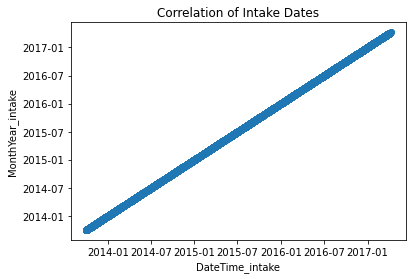

In [24]:
# how correlated are the DateTime
x = dates_df['DateTime_intake']
y = dates_df['MonthYear_intake']

plt.figure()
plt.scatter(x, y)
plt.xlabel('DateTime_intake')
plt.ylabel('MonthYear_intake')
plt.title('Correlation of Intake Dates')
plt.show()

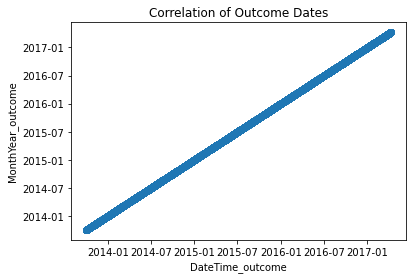

In [25]:
x = dates_df['DateTime_outcome']
y = dates_df['MonthYear_outcome']

plt.figure()
plt.scatter(x, y)
plt.xlabel('DateTime_outcome')
plt.ylabel('MonthYear_outcome')
plt.title('Correlation of Outcome Dates')
plt.show()


These columns seem to have been different formats with the same information before. Now that they are in the same format, using the drop_duplicates function will show that they are redundant columns. 

In [26]:
#run this to compare to the columns after the drop function to see which were dropped
dates_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DateTime_intake    30042 non-null  datetime64[ns]
 1   MonthYear_intake   30042 non-null  datetime64[ns]
 2   DateTime_outcome   30042 non-null  datetime64[ns]
 3   MonthYear_outcome  30042 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 1.1+ MB


In [27]:
# drop duplicates and compare info command to see which were dropped
dates_df = dates_df.T.drop_duplicates().T
dates_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateTime_intake   30042 non-null  datetime64[ns]
 1   DateTime_outcome  30042 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 1.7+ MB


The MonthYear columns from both intake and outcome were dropped. This confirms that these were redundant columns in different formats previously. Since they are redundant, they can also be dropped from the shelter_df. 

In [28]:
#drop them from the shelter_df since they are duplicates
shelter_df.drop(['MonthYear_intake', 'MonthYear_outcome'], axis=1, inplace=True)

In [29]:
#convert the remaining date columns in the shelter_df to be datetime format
#I will include DOB since it is also a date while I'm at it
for column in shelter_df[['DateTime_intake', 'DateTime_outcome', 'Date of Birth']]:
    shelter_df[column] = pd.to_datetime(shelter_df[column]) 

In [30]:
#check that columns were dropped and formats changed as intended 
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31134 entries, A683644 to A746072
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name_intake       25659 non-null  object        
 1   DateTime_intake   31134 non-null  datetime64[ns]
 2   Found_Location    31134 non-null  object        
 3   Intake_Type       31134 non-null  object        
 4   IntakeCondition   31134 non-null  object        
 5   Sex               31133 non-null  object        
 6   Age               31134 non-null  object        
 7   Breed_intake      31134 non-null  object        
 8   Color_intake      31134 non-null  object        
 9   DateTime_outcome  31134 non-null  datetime64[ns]
 10  Outcome_Type      31133 non-null  object        
 11  Outcome_Subtype   10294 non-null  object        
 12  Sex_upon_Outcome  31132 non-null  object        
 13  Age_upon_Outcome  31133 non-null  object        
 14  gender_intake     3

Now that the date columns have been explored and cleaned, I will look into the length columns. I suspect that similar to the dates columns, the length columns are duplicates with different formats as well. 

In [31]:
#what kind of data is in this column?
shelter_df['Days_length'].unique()

array(['12 weeks - 6 months', '0-7 days', '1-3 weeks', '7-12 weeks',
       '3-6 weeks', '1-2 years', nan, '6-12 months', '2+ years'],
      dtype=object)

In [32]:
#what is the distribution of these bins
shelter_df['Days_length'].value_counts()

0-7 days               18021
1-3 weeks               6815
3-6 weeks               2162
7-12 weeks              1541
12 weeks - 6 months      832
6-12 months              445
1-2 years                181
2+ years                  45
Name: Days_length, dtype: int64

In [33]:
#how many null values?
shelter_df['Days_length'].isna().sum()

1092

The 'Days_length' column is binned. There are 1092 missing values. I will now compare this with the 'DateTime_length' column. 

In [34]:
#what kind of data is in this column?
shelter_df['DateTime_length'].unique()

array(['115 days 23:04:00.000000000', '3 days 09:53:00.000000000',
       '4 days 00:47:00.000000000', ..., '1 days 00:53:00.000000000',
       '-2 days +01:14:00.000000000', '17 days 01:32:00.000000000'],
      dtype=object)

In [35]:
#what is the distribution of these bins
shelter_df['DateTime_length'].value_counts()

0 days 01:19:00.000000000       19
0 days 02:14:00.000000000       19
0 days 00:45:00.000000000       18
0 days 01:32:00.000000000       18
0 days 02:40:00.000000000       17
                                ..
-62 days +00:53:00.000000000     1
90 days 04:56:00.000000000       1
101 days 01:05:00.000000000      1
40 days 23:21:00.000000000       1
17 days 01:32:00.000000000       1
Name: DateTime_length, Length: 16834, dtype: int64

In [36]:
#how many null values?
shelter_df['DateTime_length'].isna().sum()

0

Unexpectedly, the 'DateTime_length' is not binned, but in number of days. The binned data will be useful for EDA and the number of days could be useful for modeling. I will clean this column to only include the number of days in the shelter, excluding more minute time details. 

In [37]:
# are there any negative values?
shelter_df['DateTime_length'].value_counts().sample(20)

5 days 08:56:00.000000000      1
10 days 19:16:00.000000000     1
3 days 22:19:00.000000000      2
6 days 02:01:00.000000000      9
50 days 01:51:00.000000000     1
11 days 21:43:00.000000000     2
14 days 00:09:00.000000000     1
11 days 06:17:00.000000000     1
47 days 04:50:00.000000000     1
122 days 21:06:00.000000000    1
0 days 05:35:00.000000000      2
59 days 22:13:00.000000000     1
10 days 20:34:00.000000000     2
8 days 14:05:00.000000000      1
0 days 02:36:00.000000000      4
194 days 18:29:00.000000000    1
23 days 04:30:00.000000000     1
9 days 08:41:00.000000000      1
3 days 12:11:00.000000000      3
-4 days +06:09:00.000000000    1
Name: DateTime_length, dtype: int64

It looks like we have some negative values, so I will include them as is and try to figure out why that is.

In [38]:
# extracing the days from this column, including the negative sign and excluding the word "day" and any other detail
# extract 3 numbers together, or 2 numbers together or 1 number from the string
shelter_df['DateTime_length'].str.extract(r'(.[0-9]{,3})', expand=False)

Animal ID
A683644    115
A676515      3
A742953      4
A692161      6
A720597      7
          ... 
A746624      1
A746460      4
A746689      0
A746466      4
A746072      4
Name: DateTime_length, Length: 31134, dtype: object

In [39]:
#save the day lengths into that column
shelter_df['DateTime_length'] = shelter_df['DateTime_length'].str.extract(r'(.[0-9]{,3})', expand=False)

In [40]:
#no null created in the extraction
shelter_df['DateTime_length'].isna().sum()

0

In [41]:
shelter_df['DateTime_length'].value_counts().head(20)

0     4357
4     4061
5     2338
1     2121
3     1883
6     1643
2     1618
7     1183
8     1004
9      901
10     786
11     586
12     433
13     361
14     312
16     252
15     236
17     209
18     200
19     179
Name: DateTime_length, dtype: int64

In [42]:
#change the numbers to ints
shelter_df['DateTime_length'] = pd.to_numeric(shelter_df['DateTime_length'])

In [43]:
#take a look at the negatives
shelter_df[shelter_df['DateTime_length']<0][['DateTime_length', 'DateTime_intake', 'DateTime_outcome']].value_counts().head(20)

DateTime_length  DateTime_intake      DateTime_outcome   
-1               2015-06-19 17:17:00  2015-06-19 00:00:00    11
                 2015-04-02 14:00:00  2015-04-02 00:00:00    10
                 2016-01-25 11:47:00  2016-01-25 00:00:00     5
                 2014-06-26 11:25:00  2014-06-26 08:59:00     4
-177             2016-01-10 19:07:00  2015-07-17 19:17:00     3
-1               2014-06-26 11:25:00  2014-06-26 08:58:00     3
                 2015-04-02 14:44:00  2015-04-02 00:00:00     3
                 2015-03-30 14:39:00  2015-03-30 00:00:00     2
-98              2014-04-08 15:23:00  2013-12-31 16:42:00     2
-322             2015-01-09 11:45:00  2014-02-21 13:04:00     2
-1               2014-06-26 11:25:00  2014-06-26 08:57:00     2
-19              2015-10-29 11:47:00  2015-10-10 16:58:00     1
-20              2014-12-20 12:00:00  2014-11-30 18:20:00     1
                 2015-04-12 14:29:00  2015-03-23 17:08:00     1
                 2015-08-08 12:28:00  2015-07-

In [44]:
shelter_df[shelter_df['DateTime_length']<0]['DateTime_intake'].count()

1092

In [45]:
f"This is affecting {round(1092/31134*100, 2)}% of the data."

'This is affecting 3.51% of the data.'

All of these intake times are after the outcome time. It's likely that whoever input the data simply put it in backwards, but that means the date columns for each of these rows are also compramised. Since this is only affecting 3.5% of the data, I am going to drop these columns. 

In [46]:
#check to see if it worked
shelter_df=shelter_df[shelter_df['DateTime_length']>=0]

The lengths are still in float type, but I'm not sure why. I tried several methods to fix this including int(), astype() and a for loop to no avail. It's going to take up more space than necessary, but it's not worth the extra time to continue trouble shooting this issue. 
I would like to see how closely correlated these two length columns are. I will do this by binning the 'DateTime_length' column and plotting these two binned columns on the x and y axis to see if they are 1:1 correlated. 

In [47]:
# I'm going to bin the data to compare these two columns
# source: https://towardsdatascience.com/sort-and-segment-your-data-into-bins-to-get-sorted-ranges-pandas-cut-and-qcut-7785931bbfde
cut_length = ['0-7 days', "1-3 weeks", '3-6 weeks', '7-12 weeks', '12 weeks - 6 months', 
              '6-12 months', '1-2 years', '2+ years']
cut_bins =[-1, 7, 21, 42, 84, 183, 365, 730, max(shelter_df['DateTime_length'])]
binned_DateTime_length = pd.cut(shelter_df['DateTime_length'], bins=cut_bins, labels = cut_length)
binned_DateTime_length.isna().sum()

0

Not sure where these NaN values came from, but they are the same quantity as the NaNs in 'Days_length' so it shouldn't affect my comparison of the two columns. 

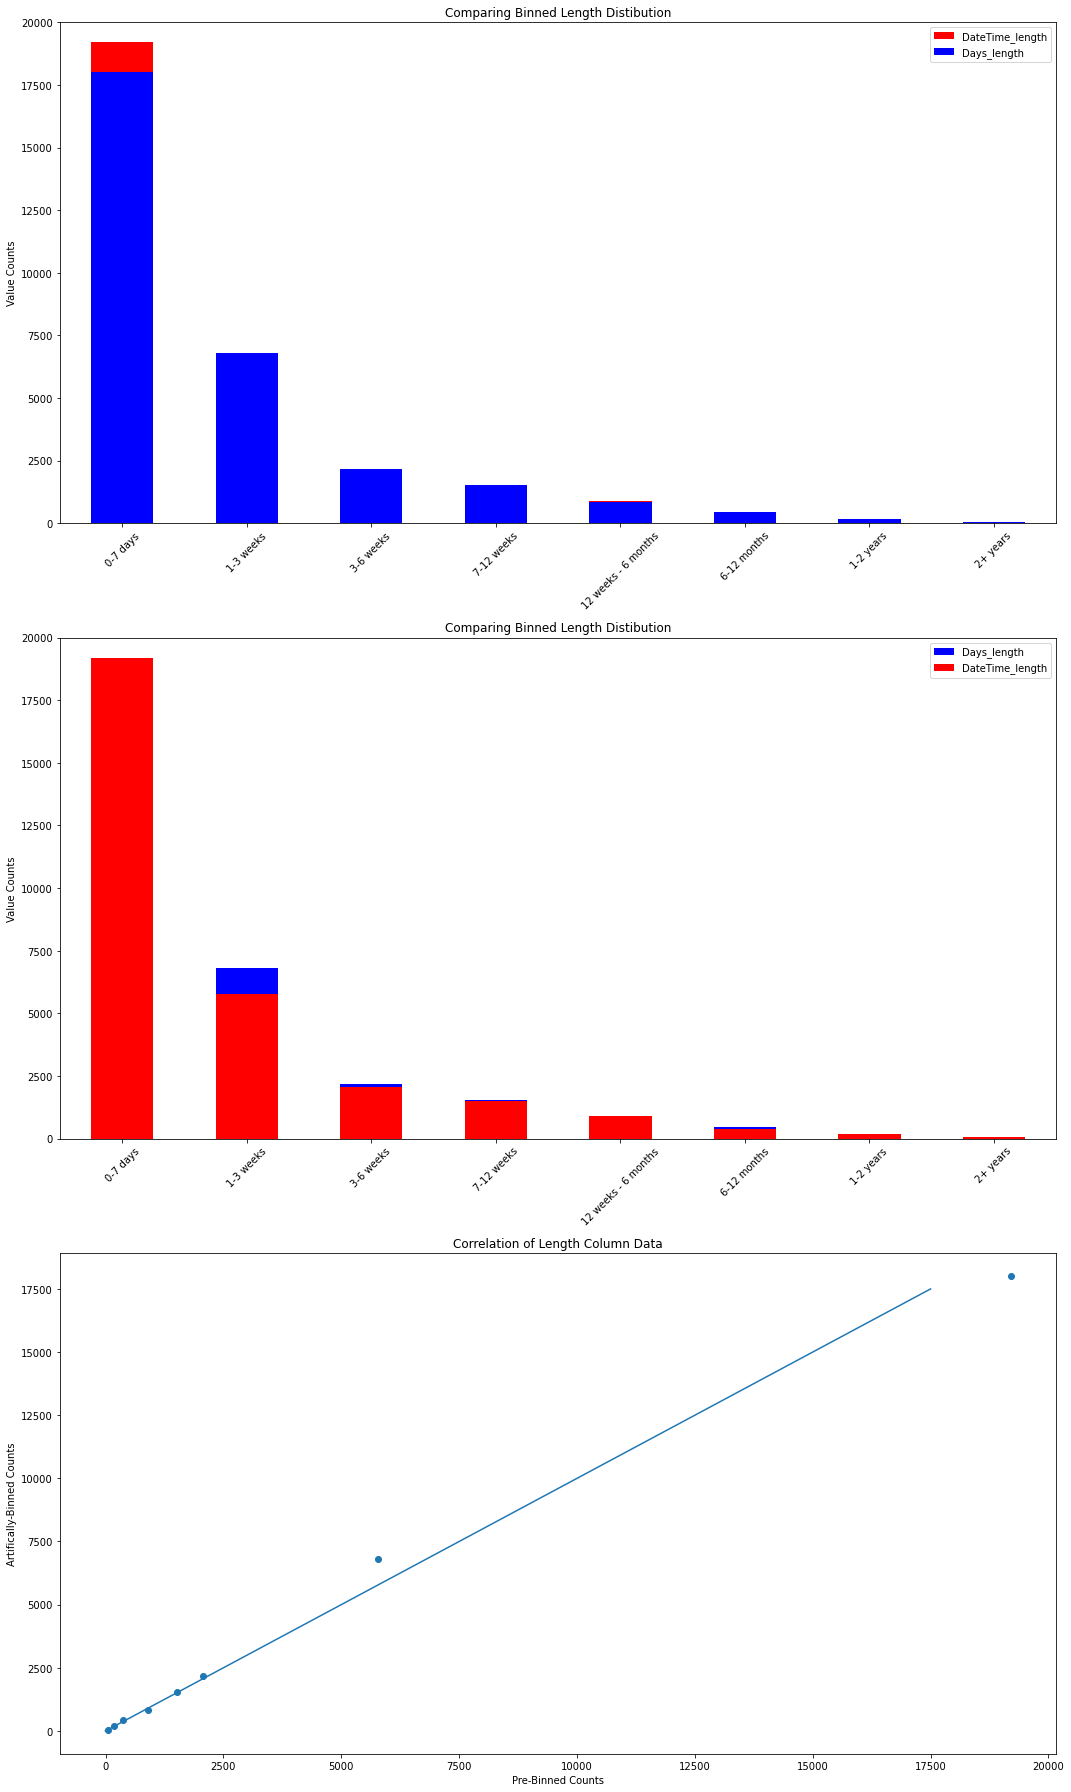

In [48]:
x = np.linspace(-5,17500,100)
y = x

plt.figure(figsize=(15, 25))

plt.subplot(3, 1, 1)
binned_DateTime_length.value_counts().plot(kind='bar', label='DateTime_length', color='red')
shelter_df['Days_length'].value_counts().plot(kind='bar', label ='Days_length', color='blue')
plt.legend()
plt.ylabel('Value Counts')
plt.ylim((0,20000))
plt.xticks(rotation=45)
plt.title('Comparing Binned Length Distibution')

plt.subplot(3, 1, 2)
shelter_df['Days_length'].value_counts().plot(kind='bar', label ='Days_length', color='blue')
binned_DateTime_length.value_counts().plot(kind='bar', label='DateTime_length', color='red')
plt.legend()
plt.ylabel('Value Counts')
plt.ylim((0,20000))
plt.xticks(rotation=45)
plt.title('Comparing Binned Length Distibution')

plt.subplot(3,1, 3)
plt.scatter(binned_DateTime_length.value_counts(), shelter_df['Days_length'].value_counts())
plt.xlabel('Pre-Binned Counts')
plt.ylabel('Artifically-Binned Counts')
plt.title('Correlation of Length Column Data')
plt.plot(x,y)

plt.tight_layout()
plt.show()

It looks like the original binning process was not as straight forward as hopped or the labels were not very accurate, so there are some slight differences in the distributions above. In the first bar chart I plotting 'Days_length' on top of 'DateTime_length' and it's clear there are more dogs in the 0-7 day category for 'DateTime_length' bins as well the 12 weeks -6 month bin. For the second chart, I did the opposite and you can see there are more dogs in the 1-3 week bin for 'Days_length' column as well as 3-6 weeks, 6-12 months and 2+years. Despite the binning issue, their distributions are quite similar and they are highly correlated. For this reason, I feel comfortable using 'Days_length' for EDA purposes while modeling with 'DateTime_length'. If an issue arises around this or if this column becomes fundamental to the accuracy of the model in the future, I will reconsider the accuracy of this data. 

Now I will get these cleaned columns into the EDA df and drop 'Days_length' from the modeling df

In [49]:
# Add columns to the EDA dataframe that don't need to be updated first
EDA_shelter_df = shelter_df[['Name_intake', 'Found_Location', 'Intake_Type', 'IntakeCondition', 
                             'Outcome_Type', 'Outcome_Subtype', 'gender_intake', 'fixed_changed', 'fixed_intake', 
                             'fixed_outcome', 'Breed_intake', 'Color_intake', 'Date of Birth', 'Age_Bucket', 
                             'Days_length']]

#checking that I did what was intended
EDA_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name_intake      24606 non-null  object        
 1   Found_Location   30042 non-null  object        
 2   Intake_Type      30042 non-null  object        
 3   IntakeCondition  30042 non-null  object        
 4   Outcome_Type     30041 non-null  object        
 5   Outcome_Subtype  10152 non-null  object        
 6   gender_intake    29884 non-null  object        
 7   fixed_changed    30042 non-null  object        
 8   fixed_intake     30041 non-null  object        
 9   fixed_outcome    30040 non-null  object        
 10  Breed_intake     30042 non-null  object        
 11  Color_intake     30042 non-null  object        
 12  Date of Birth    30042 non-null  datetime64[ns]
 13  Age_Bucket       30042 non-null  object        
 14  Days_length      30042 non-null  ob

In [50]:
#add the cleaned date columns for EDA purposes
EDA_shelter_df[['intake_date', 'outcome_date']] = dates_df[['DateTime_intake', 'DateTime_outcome']]
#checking that I did what was intended
EDA_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name_intake      24606 non-null  object        
 1   Found_Location   30042 non-null  object        
 2   Intake_Type      30042 non-null  object        
 3   IntakeCondition  30042 non-null  object        
 4   Outcome_Type     30041 non-null  object        
 5   Outcome_Subtype  10152 non-null  object        
 6   gender_intake    29884 non-null  object        
 7   fixed_changed    30042 non-null  object        
 8   fixed_intake     30041 non-null  object        
 9   fixed_outcome    30040 non-null  object        
 10  Breed_intake     30042 non-null  object        
 11  Color_intake     30042 non-null  object        
 12  Date of Birth    30042 non-null  datetime64[ns]
 13  Age_Bucket       30042 non-null  object        
 14  Days_length      30042 non-null  ob

In [51]:
#now that this column is in the EDA df, I won't need it in this df anymore
shelter_df.drop('Days_length', axis=1, inplace=True)

#checking that they're really dropped
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name_intake       24606 non-null  object        
 1   DateTime_intake   30042 non-null  datetime64[ns]
 2   Found_Location    30042 non-null  object        
 3   Intake_Type       30042 non-null  object        
 4   IntakeCondition   30042 non-null  object        
 5   Sex               30041 non-null  object        
 6   Age               30042 non-null  object        
 7   Breed_intake      30042 non-null  object        
 8   Color_intake      30042 non-null  object        
 9   DateTime_outcome  30042 non-null  datetime64[ns]
 10  Outcome_Type      30041 non-null  object        
 11  Outcome_Subtype   10152 non-null  object        
 12  Sex_upon_Outcome  30040 non-null  object        
 13  Age_upon_Outcome  30041 non-null  object        
 14  gender_intake     2

Now that the columns related to dates and times are explored, cleaned and sorted into their respective dfs, I will do the same for the breed information. 

## Breed Columns
<a class="anchor" id="breed"></a>

There are already 10 dummy columns for the breeds of dogs. There is a possibility that these will be enough to model with and the categorical breed column could be dropped in this case. I will explore the data first and then determine the best plan of action moving forward. 

In [52]:
#how many unique breeds are listed
pd.DataFrame(shelter_df['Breed_intake'].unique())
# 1759 unique mixes

,0
0,Border Collie Mix
1,Pit Bull Mix
2,Saluki
3,Anatol Shepherd Mix
4,Boxer/Labrador Retriever
...,...
1715,Australian Kelpie/Bull Terrier
1716,Australian Kelpie/Border Collie
1717,Brittany/Border Collie
1718,Akita/Mastiff


There are 1759 unique breed combinations, but many of these are mixed breeds, so there are likely fewer breeds actually represented in the data. The 10 bins already in the df are:
* retriever        
* shepherd       
* beagle       
* terrier      
* boxer        
* poodle        
* rottweiler        
* dachshund        
* chihuahua       
* pit bull

 Let me look at the most common mixes from this column and see if there is overlap.

In [53]:
shelter_df['Breed_intake'].value_counts().head(20)

Pit Bull Mix                 3791
Chihuahua Shorthair Mix      3448
Labrador Retriever Mix       2952
German Shepherd Mix          1253
Australian Cattle Dog Mix     745
Dachshund Mix                 611
Miniature Poodle Mix          460
Border Collie Mix             421
Boxer Mix                     410
Australian Shepherd Mix       329
Rat Terrier Mix               316
Jack Russell Terrier Mix      301
Yorkshire Terrier Mix         298
Catahoula Mix                 298
Miniature Schnauzer Mix       286
Chihuahua Longhair Mix        261
Beagle Mix                    256
Siberian Husky Mix            254
Cairn Terrier Mix             245
Great Pyrenees Mix            229
Name: Breed_intake, dtype: int64

Pit Bulls, Chihuahuas, Labradors and German Shepherd are the most common, but Labradors are not represented in the original bins. To start I will try to pull out the breeds from the `Breed_intake` list and sort it into the established bins and see how many are missing. I will do this by splitting the dogs with multiple breeds listed, creating more breed bins to represent the most common 20 breeds and then creating a function to recognize the breed and enter a dummy into one of those columns if applicable. 

In [54]:
# Split up the entries with multiple breeds seperated by the '/' delimitor 
shelter_df[['Breed1', 'Breed2', 'Breed3']] = shelter_df.Breed_intake.str.split("/", expand=True)

shelter_df[['Breed1', 'Breed2', 'Breed3']].isna().sum()

Breed1        0
Breed2    24898
Breed3    30023
dtype: int64

In [55]:
#add dummy columns for 6 breeds that were in the top 20, but not already encapsulated in the original bins
columns_to_add = ['cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 'pyrenees', 'other_breeds']        

for i in range(len(columns_to_add)):
    shelter_df[columns_to_add[i]] = [0]*30042

Now that the breeds are split and the columns are created for the dummy variables, I will create a function to recognize which breed the dog is and add a dummy to the corresponding dummy variable column. Starting with: 
* retriever        
* shepherd       
* beagle       
* terrier      
* boxer        
* poodle        
* rottweiler        
* dachshund        
* chihuahua       
* pit bull
* cattle dog
* border collie
* catahoula
* schnauzer
* husky
* pyrenees

In [56]:
# sort the dogs into their breeds (not mutually exclusive bins)
def breed_dummies(df, column):     
    for i , row in enumerate(df.values):


        # skip the nulls
        if pd.isnull(column[i]) == True:
            pass

        #breeds that were already dummified
        elif re.findall(r"(.*[R|r]etriever.*)", column[i]):
            if shelter_df['retriever'][i] == 0:
                shelter_df['retriever'][i] += 1
                
        elif re.findall(r"(.*[S|s]hepherd.*)", column[i]):
            if shelter_df['shepherd'][i] == 0:
                shelter_df['shepherd'][i] += 1
                
        elif re.findall(r"(.*[B|b]eagle.*)", column[i]):
            if shelter_df['beagle'][i] == 0:
                shelter_df['beagle'][i] += 1
                
        elif re.findall(r"(.*[T|t]errier.*)", column[i]):
            if shelter_df['terrier'][i] == 0:
                shelter_df['terrier'][i] += 1
                
        elif re.findall(r"(.*[B|b]oxer.*)", column[i]):
            if shelter_df['boxer'][i] == 0:
                shelter_df['boxer'][i] += 1
                
        elif re.findall(r"(.*[P|p]oodle.*)", column[i]):
            if shelter_df['poodle'][i] == 0:
                shelter_df['poodle'][i] += 1
                
        elif re.findall(r"(.*[R|r]ottweiler.*)", column[i]):    
            if shelter_df['rottweiler'][i] == 0:
                shelter_df['rottweiler'][i] += 1
                
        elif re.findall(r"(.*[D|d]achshund.*)", column[i]):
            if shelter_df['dachshund'][i] == 0:
                shelter_df['dachshund'][i] += 1
                
        elif re.findall(r"(.*[C|c]hihuahua.*)", column[i]):
            if shelter_df['chihuahua'][i] == 0:
                shelter_df['chihuahua'][i] += 1
                
        elif re.findall(r"(.*[P|p]it [B|b]ull.*)", column[i]):
            if shelter_df['pit bull'][i] == 0:
                shelter_df['pit bull'][i] += 1



        #these breeds were not dummies in original data, but are top 20 in this data            
        elif re.findall(r"(.*[C|c]attle [D|d]og.*)", column[i]):
            if shelter_df['cattle dog'][i] == 0:
                shelter_df['cattle dog'][i] += 1
                
        elif re.findall(r"(.*[C|c]ollie.*)", column[i]):
            if shelter_df['collie'][i] == 0:
                shelter_df['collie'][i] += 1
                   
        elif re.findall(r"(.*[C|c]atahoula.*)", column[i]):
            if shelter_df['catahoula'][i] == 0:
                shelter_df['catahoula'][i] += 1
                
        elif re.findall(r"(.*[S|s]chnauzer.*)", column[i]):
            if shelter_df['schnauzer'][i] == 0:
                shelter_df['schnauzer'][i] += 1
                
        elif re.findall(r"(.*[H|h]usky.*)", column[i]):
            if shelter_df['husky'][i] == 0:
                shelter_df['husky'][i] += 1
                
        elif re.findall(r"(.*[P|p]yrenees.*)", column[i]):
            if shelter_df['pyrenees'][i] == 0:
                shelter_df['pyrenees'][i] += 1
            
        else:
            if shelter_df['other_breeds'][i] == 0:
                shelter_df['other_breeds'][i] += 1
            # of the single entry breeds, only 1965 in the 'other' column with these 31 breeds

In [57]:
# shows there are dummies already from the original data
shelter_df[['retriever', 'shepherd', 'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 'chihuahua', 
            'pit bull', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 'pyrenees', 'other_breeds']].sum()


retriever       4836
shepherd        2686
beagle           573
terrier         3054
boxer            746
poodle           962
rottweiler       383
dachshund       1462
chihuahua       4933
pit bull        4630
cattle dog         0
collie             0
catahoula          0
schnauzer          0
husky              0
pyrenees           0
other_breeds       0
dtype: object

In [58]:
#checking dummies for single select breeds and adding new dummies for additional breeds
breed_dummies(shelter_df, shelter_df['Breed1'])

In [59]:
#making dummies for first of multi select
breed_dummies(shelter_df, shelter_df['Breed2'])

In [60]:
#making dummies for second of multi select
breed_dummies(shelter_df, shelter_df['Breed3'])

In [61]:
# see the difference after running the function on the split breed columns
shelter_df[['retriever', 'shepherd', 'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 'chihuahua', 
            'pit bull', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 'pyrenees', 'other_breeds']].sum()


retriever       4836
shepherd        2686
beagle           573
terrier         3054
boxer            746
poodle           962
rottweiler       383
dachshund       1462
chihuahua       4933
pit bull        4630
cattle dog      1199
collie           883
catahoula        485
schnauzer        532
husky            464
pyrenees         392
other_breeds    6638
dtype: object

There are quite a few breeds added to the 'other_breed' bin, so I would like to add some more dummy variable columns to account for that. I will use the next 10 most popular breeds to add to the function and check again to see how many dogs fall into the 'other_breeds' column after that.

In [62]:
#what are the next 10 most popular dogs breeds in this dataset
shelter_df['Breed_intake'].value_counts()[20:30]

Rottweiler Mix                   219
Shih Tzu Mix                     202
Pointer Mix                      201
American Bulldog Mix             194
Chihuahua Shorthair/Dachshund    188
Staffordshire Mix                169
Australian Kelpie Mix            164
Plott Hound Mix                  161
Black Mouth Cur Mix              158
Chihuahua Shorthair              153
Name: Breed_intake, dtype: int64

Looking at the 'Chihuahua Shorthair/Dachshund' it's clear that specific mixes are starting to be part of the most popular breeds. I will makes sure to consider both/all breeds in the combination when adding each breed to the function.

Rottweiler, Chihuahua and Dachshund are already represented in the dummy variables, so I will add:
* Shih Tzu Mix
* Pointer Mix
* American Bulldog Mix
* Staffordshire Mix
* Australian Kelpie Mix
* Black Mouth Cur Mix
* Plott Hound Mix 

In [63]:
#add dummy columns for 7 breeds that were in the top 20-30, but not already encapsulated in the bins
columns_to_add = ['shih tzu', 'pointer', 'bulldog', 'kelpie', 'black mouth cur', 'hound', 'other_breeds']        

for i in range(len(columns_to_add)):
    shelter_df[columns_to_add[i]] = [0]*30042

In [64]:
#added up to top 30 breeds

# sort the dogs into their breeds (not mutually exclusive bins)
def breed_dummies(df, column):     
    for i , row in enumerate(df.values):


        # skip the nulls
        if pd.isnull(column[i]) == True:
            pass

        #breeds that were already dummified
        elif re.findall(r"(.*[R|r]etriever.*)", column[i]):
            if shelter_df['retriever'][i] == 0:
                shelter_df['retriever'][i] += 1
                
        elif re.findall(r"(.*[S|s]hepherd.*)", column[i]):
            if shelter_df['shepherd'][i] == 0:
                shelter_df['shepherd'][i] += 1
                
        elif re.findall(r"(.*[B|b]eagle.*)", column[i]):
            if shelter_df['beagle'][i] == 0:
                shelter_df['beagle'][i] += 1
                
        elif re.findall(r"(.*[T|t]errier.*)", column[i]):
            if shelter_df['terrier'][i] == 0:
                shelter_df['terrier'][i] += 1
                
        elif re.findall(r"(.*[B|b]oxer.*)", column[i]):
            if shelter_df['boxer'][i] == 0:
                shelter_df['boxer'][i] += 1
                
        elif re.findall(r"(.*[P|p]oodle.*)", column[i]):
            if shelter_df['poodle'][i] == 0:
                shelter_df['poodle'][i] += 1
                
        elif re.findall(r"(.*[R|r]ottweiler.*)", column[i]):    
            if shelter_df['rottweiler'][i] == 0:
                shelter_df['rottweiler'][i] += 1
                
        elif re.findall(r"(.*[D|d]achshund.*)", column[i]):
            if shelter_df['dachshund'][i] == 0:
                shelter_df['dachshund'][i] += 1
                
        elif re.findall(r"(.*[C|c]hihuahua.*)", column[i]):
            if shelter_df['chihuahua'][i] == 0:
                shelter_df['chihuahua'][i] += 1
                
        elif re.findall(r"(.*[P|p]it [B|b]ull.*)|(.*[S|s]taffordshire.*)", column[i]):
            if shelter_df['pit bull'][i] == 0:
                shelter_df['pit bull'][i] += 1



        #these breeds were not dummies in original data, but are top 20 in this data            
        elif re.findall(r"(.*[C|c]attle [D|d]og.*)", column[i]):
            if shelter_df['cattle dog'][i] == 0:
                shelter_df['cattle dog'][i] += 1
                
        elif re.findall(r"(.*[C|c]ollie.*)", column[i]):
            if shelter_df['collie'][i] == 0:
                shelter_df['collie'][i] += 1
                   
        elif re.findall(r"(.*[C|c]atahoula.*)", column[i]):
            if shelter_df['catahoula'][i] == 0:
                shelter_df['catahoula'][i] += 1
                
        elif re.findall(r"(.*[S|s]chnauzer.*)", column[i]):
            if shelter_df['schnauzer'][i] == 0:
                shelter_df['schnauzer'][i] += 1
                
        elif re.findall(r"(.*[H|h]usky.*)", column[i]):
            if shelter_df['husky'][i] == 0:
                shelter_df['husky'][i] += 1
                
        elif re.findall(r"(.*[P|p]yrenees.*)", column[i]):
            if shelter_df['pyrenees'][i] == 0:
                shelter_df['pyrenees'][i] += 1

        #these 20-30 most popular breeds
        elif re.findall(r"(.*[S|s]hih [T|t]zu.*)", column[i]):
            if shelter_df['shih tzu'][i] == 0:
                shelter_df['shih tzu'][i] += 1
                
        elif re.findall(r"(.*[P|p]ointer.*)", column[i]):
            if shelter_df['pointer'][i] == 0:
                shelter_df['pointer'][i] += 1
                
        elif re.findall(r"(.*[B|b]ulldog.*)", column[i]):
            if shelter_df['bulldog'][i] == 0:
                shelter_df['bulldog'][i] += 1
                
        elif re.findall(r"(.*[K|k]elpie.*)", column[i]):
            if shelter_df['kelpie'][i] == 0:
                shelter_df['kelpie'][i] += 1
                
        elif re.findall(r"(.*[M|m]outh [C|c]ur.*)", column[i]):
            if shelter_df['black mouth cur'][i] == 0:
                shelter_df['black mouth cur'][i] += 1
                            
        elif re.findall(r"(.*[H|h]ound.*)", column[i]):
            if shelter_df['hound'][i] == 0:
                shelter_df['hound'][i] += 1
                
                
                
        else:
            if shelter_df['other_breeds'][i] == 0:
                shelter_df['other_breeds'][i] += 1
            # of the single entry breeds, only 1965 in the 'other' column with these 31 breeds

In [65]:
#make sure those columns were created correctly and to compare numbers after running the function
shelter_df[['retriever', 'shepherd', 'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 'chihuahua', 
            'pit bull', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 'pyrenees', 'shih tzu', 'pointer', 
            'bulldog', 'kelpie', 'black mouth cur', 'hound','other_breeds']].sum()

retriever          4836
shepherd           2686
beagle              573
terrier            3054
boxer               746
poodle              962
rottweiler          383
dachshund          1462
chihuahua          4933
pit bull           4630
cattle dog         1199
collie              883
catahoula           485
schnauzer           532
husky               464
pyrenees            392
shih tzu              0
pointer               0
bulldog               0
kelpie                0
black mouth cur       0
hound                 0
other_breeds          0
dtype: object

In [66]:
#checking dummies for single select breeds and adding new dummies for additional breeds
breed_dummies(shelter_df, shelter_df['Breed1'])

#making dummies for first of multi select
breed_dummies(shelter_df, shelter_df['Breed2'])

#making dummies for second of multi select
breed_dummies(shelter_df, shelter_df['Breed3'])

In [67]:
#make sure the function worked
shelter_df[['retriever', 'shepherd', 'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 'chihuahua', 
            'pit bull', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 'pyrenees', 'shih tzu', 'pointer', 
            'bulldog', 'kelpie', 'black mouth cur', 'hound','other_breeds']].sum()

retriever          4836
shepherd           2686
beagle              573
terrier            3054
boxer               746
poodle              962
rottweiler          383
dachshund          1462
chihuahua          4933
pit bull           4846
cattle dog         1199
collie              883
catahoula           485
schnauzer           532
husky               464
pyrenees            392
shih tzu            352
pointer             424
bulldog             402
kelpie              229
black mouth cur     210
hound               803
other_breeds       4209
dtype: object

In [68]:
f"There are now 4336 dogs with breeds not listed in the breed dummy variables, that is {round(4336/31115*100, 2)}% of dogs in this df."

'There are now 4336 dogs with breeds not listed in the breed dummy variables, that is 13.94% of dogs in this df.'

It went from almost 7000 'other_breeds' to 4500 'other_breeds' by adding the 7 more dummy variables but I would ideally like that to be under 10%, so I will add a few more "common" breeds using the same approach as before. 

In [69]:
#what are the next 10 most popular dogs breeds in this dataset
shelter_df['Breed_intake'].value_counts()[30:60]

Pit Bull                              146
Labrador Retriever/Pit Bull           144
Labrador Retriever                    144
American Staffordshire Terrier Mix    142
Anatol Shepherd Mix                   141
Dachshund/Chihuahua Shorthair         134
German Shepherd                       134
Golden Retriever Mix                  126
Queensland Heeler Mix                 124
Miniature Pinscher Mix                120
Maltese Mix                           113
Chow Chow Mix                         112
German Shepherd/Labrador Retriever    105
American Pit Bull Terrier Mix         103
Labrador Retriever/German Shepherd     98
Pug Mix                                94
Lhasa Apso Mix                         90
Cardigan Welsh Corgi Mix               88
Pomeranian Mix                         88
Shih Tzu                               87
Dachshund                              87
Toy Poodle Mix                         81
Doberman Pinsch Mix                    81
Cocker Spaniel Mix                

Considering the next 30 most common breeds in this data frame, I will add these 11 breeds that were not encapsulated in the other bins already created:
* Queensland Heeler Mix
* Miniature Pinscher Mix
* Maltese Mix
* Chow Chow Mix
* Pug Mix
* Lhasa Apso Mix
* Pomeranian Mix
* Cardigan Welsh Corgi Mix
* Doberman Pinsch Mix
* Cocker Spaniel Mix
* Blue Lacy Mix

In [70]:
#add dummy columns for 7 breeds that were in the top 20-30, but not already encapsulated in the bins
columns_to_add = ['heeler', 'pinscher', 'maltese', 'chow', 'pug', 'lhasa apso', 'pomeranian', 'corgi', 'spaniel', 
                  'blue lacy', 'other_breeds']        

for i in range(len(columns_to_add)):
    shelter_df[columns_to_add[i]] = [0]*30042

In [71]:
# sort the dogs into their breeds (not mutually exclusive bins)
def breed_dummies(df, column):     
    for i , row in enumerate(df.values):


        # skip the nulls
        if pd.isnull(column[i]) == True:
            pass

        #breeds that were already dummified
        elif re.findall(r"(.*[R|r]etriever.*)", column[i]):
            if shelter_df['retriever'][i] == 0:
                shelter_df['retriever'][i] += 1
                
        elif re.findall(r"(.*[S|s]hepherd.*)", column[i]):
            if shelter_df['shepherd'][i] == 0:
                shelter_df['shepherd'][i] += 1
                
        elif re.findall(r"(.*[B|b]eagle.*)", column[i]):
            if shelter_df['beagle'][i] == 0:
                shelter_df['beagle'][i] += 1
                
        elif re.findall(r"(.*[T|t]errier.*)", column[i]):
            if shelter_df['terrier'][i] == 0:
                shelter_df['terrier'][i] += 1
                
        elif re.findall(r"(.*[B|b]oxer.*)", column[i]):
            if shelter_df['boxer'][i] == 0:
                shelter_df['boxer'][i] += 1
                
        elif re.findall(r"(.*[P|p]oodle.*)", column[i]):
            if shelter_df['poodle'][i] == 0:
                shelter_df['poodle'][i] += 1
                
        elif re.findall(r"(.*[R|r]ottweiler.*)", column[i]):    
            if shelter_df['rottweiler'][i] == 0:
                shelter_df['rottweiler'][i] += 1
                
        elif re.findall(r"(.*[D|d]achshund.*)", column[i]):
            if shelter_df['dachshund'][i] == 0:
                shelter_df['dachshund'][i] += 1
                
        elif re.findall(r"(.*[C|c]hihuahua.*)", column[i]):
            if shelter_df['chihuahua'][i] == 0:
                shelter_df['chihuahua'][i] += 1
                
        elif re.findall(r"(.*[P|p]it [B|b]ull.*)|(.*[S|s]taffordshire.*)", column[i]):
            if shelter_df['pit bull'][i] == 0:
                shelter_df['pit bull'][i] += 1


        #these breeds were not dummies in original data, but are top 20 in this data            
        elif re.findall(r"(.*[C|c]attle [D|d]og.*)", column[i]):
            if shelter_df['cattle dog'][i] == 0:
                shelter_df['cattle dog'][i] += 1
                
        elif re.findall(r"(.*[C|c]ollie.*)", column[i]):
            if shelter_df['collie'][i] == 0:
                shelter_df['collie'][i] += 1
                   
        elif re.findall(r"(.*[C|c]atahoula.*)", column[i]):
            if shelter_df['catahoula'][i] == 0:
                shelter_df['catahoula'][i] += 1
                
        elif re.findall(r"(.*[S|s]chnauzer.*)", column[i]):
            if shelter_df['schnauzer'][i] == 0:
                shelter_df['schnauzer'][i] += 1
                
        elif re.findall(r"(.*[H|h]usky.*)", column[i]):
            if shelter_df['husky'][i] == 0:
                shelter_df['husky'][i] += 1
                
        elif re.findall(r"(.*[P|p]yrenees.*)", column[i]):
            if shelter_df['pyrenees'][i] == 0:
                shelter_df['pyrenees'][i] += 1

        #these 20-30 most popular breeds
        elif re.findall(r"(.*[S|s]hih [T|t]zu.*)", column[i]):
            if shelter_df['shih tzu'][i] == 0:
                shelter_df['shih tzu'][i] += 1
                
        elif re.findall(r"(.*[P|p]ointer.*)", column[i]):
            if shelter_df['pointer'][i] == 0:
                shelter_df['pointer'][i] += 1
                
        elif re.findall(r"(.*[B|b]ulldog.*)", column[i]):
            if shelter_df['bulldog'][i] == 0:
                shelter_df['bulldog'][i] += 1
                
        elif re.findall(r"(.*[K|k]elpie.*)", column[i]):
            if shelter_df['kelpie'][i] == 0:
                shelter_df['kelpie'][i] += 1
                
        elif re.findall(r"(.*[M|m]outh [C|c]ur.*)", column[i]):
            if shelter_df['black mouth cur'][i] == 0:
                shelter_df['black mouth cur'][i] += 1
                            
        elif re.findall(r"(.*[H|h]ound.*)", column[i]):
            if shelter_df['hound'][i] == 0:
                shelter_df['hound'][i] += 1
                

        #breeds in the top 60
        elif re.findall(r"(.*[H|h]eeler.*)", column[i]):
            if shelter_df['heeler'][i] == 0:
                shelter_df['heeler'][i] += 1
                
        elif re.findall(r"(.*[P|p]insch.*)", column[i]):
            if shelter_df['pinscher'][i] == 0:
                shelter_df['pinscher'][i] += 1
            
        elif re.findall(r"(.*[M|m]altese.*)", column[i]):
            if shelter_df['maltese'][i] == 0:
                shelter_df['maltese'][i] += 1
                
        elif re.findall(r"(.*[C|c]how.*)", column[i]):
            if shelter_df['chow'][i] == 0:
                shelter_df['chow'][i] += 1
                           
        elif re.findall(r"(.*[P|p]ug.*)", column[i]):
            if shelter_df['pug'][i] == 0:
                shelter_df['pug'][i] += 1
 
        elif re.findall(r"(.*[A|a]pso.*)", column[i]):
            if shelter_df['lhasa apso'][i] == 0:
                shelter_df['lhasa apso'][i] += 1
                
        elif re.findall(r"(.*[P|p]omeranian.*)", column[i]):
            if shelter_df['pomeranian'][i] == 0:
                shelter_df['pomeranian'][i] += 1
            
        elif re.findall(r"(.*[C|c]orgi.*)", column[i]):
            if shelter_df['corgi'][i] == 0:
                shelter_df['corgi'][i] += 1
                     
        elif re.findall(r"(.*[S|s]pan.*)", column[i]):
            if shelter_df['spaniel'][i] == 0:
                shelter_df['spaniel'][i] += 1
                
        elif re.findall(r"(.*[B|b]lue [L|l]acy.*)", column[i]):
            if shelter_df['blue lacy'][i] == 0:
                shelter_df['blue lacy'][i] += 1

            
        else:
            if shelter_df['other_breeds'][i] == 0:
                shelter_df['other_breeds'][i] += 1
            # of the single entry breeds, only 1965 in the 'other' column with these 31 breedsy

In [72]:
#make sure the columns added properly 
shelter_df[['retriever', 'shepherd', 'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 'chihuahua', 
            'pit bull', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 'pyrenees', 'shih tzu', 'pointer', 
            'bulldog', 'kelpie', 'black mouth cur', 'hound','heeler', 'pinscher', 'maltese', 'chow', 
            'pug', 'lhasa apso', 'pomeranian', 'corgi', 'spaniel', 'blue lacy', 'other_breeds']].sum()

retriever          4836
shepherd           2686
beagle              573
terrier            3054
boxer               746
poodle              962
rottweiler          383
dachshund          1462
chihuahua          4933
pit bull           4846
cattle dog         1199
collie              883
catahoula           485
schnauzer           532
husky               464
pyrenees            392
shih tzu            352
pointer             424
bulldog             402
kelpie              229
black mouth cur     210
hound               803
heeler                0
pinscher              0
maltese               0
chow                  0
pug                   0
lhasa apso            0
pomeranian            0
corgi                 0
spaniel               0
blue lacy             0
other_breeds          0
dtype: object

In [73]:
#checking dummies for single select breeds and adding new dummies for additional breeds
breed_dummies(shelter_df, shelter_df['Breed1'])

#making dummies for first of multi select
breed_dummies(shelter_df, shelter_df['Breed2'])

#making dummies for second of multi select
breed_dummies(shelter_df, shelter_df['Breed3'])

In [74]:
#make sure the function worked
shelter_df[['retriever', 'shepherd', 'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 'chihuahua', 
            'pit bull', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 'pyrenees', 'shih tzu', 'pointer', 
            'bulldog', 'kelpie', 'black mouth cur', 'hound','heeler', 'pinscher', 'maltese', 'chow', 
            'pug', 'lhasa apso', 'pomeranian', 'corgi', 'spaniel', 'blue lacy', 'other_breeds']].sum()

retriever          4836
shepherd           2686
beagle              573
terrier            3054
boxer               746
poodle              962
rottweiler          383
dachshund          1462
chihuahua          4933
pit bull           4846
cattle dog         1199
collie              883
catahoula           485
schnauzer           532
husky               464
pyrenees            392
shih tzu            352
pointer             424
bulldog             402
kelpie              229
black mouth cur     210
hound               803
heeler              167
pinscher            345
maltese             239
chow                257
pug                 265
lhasa apso          149
pomeranian          155
corgi               290
spaniel             285
blue lacy           126
other_breeds       2002
dtype: object

In [75]:
f"There are 2076 dogs with breeds in the 'other' category now, that is only {round(2076/30042*100, 2)}% of dogs."

"There are 2076 dogs with breeds in the 'other' category now, that is only 6.91% of dogs."

I now feel comfortable that I have a comprehensive list of all of the dog breeds represented in this dataset. I will drop the split breed columns and "other_breeds", but first I will use the split breed columns in the EDA df, then I will drop them from the shelter_df.  

In [76]:
EDA_shelter_df[['Breed1', 'Breed2', 'Breed3']] = shelter_df[['Breed1', 'Breed2', 'Breed3']]
EDA_shelter_df.head()

,Name_intake,Found_Location,Intake_Type,IntakeCondition,Outcome_Type,Outcome_Subtype,gender_intake,fixed_changed,fixed_intake,fixed_outcome,Breed_intake,Color_intake,Date of Birth,Age_Bucket,Days_length,intake_date,outcome_date,Breed1,Breed2,Breed3
Animal ID,,,,,,,,,,,,,,,,,,,,
A683644,*Zoey,Austin (TX),Owner Surrender,Nursing,Adoption,Foster,Female,1,Intact,Spayed,Border Collie Mix,Brown/White,2014-06-13,1-6 weeks,12 weeks - 6 months,2014-07-13 11:02:00,2014-11-06 10:06:00,Border Collie Mix,None,None
A676515,Rico,615 E. Wonsley in Austin (TX),Stray,Normal,Return to Owner,NaN,Male,1,Intact,Neutered,Pit Bull Mix,White/Brown,2014-01-11,1-6 months,0-7 days,2014-04-11 08:45:00,2014-04-14 18:38:00,Pit Bull Mix,None,None
A742953,NaN,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Transfer,Partner,Male,0,Intact,Intact,Saluki,Sable/Cream,2015-01-31,1-3 years,0-7 days,2017-01-31 13:30:00,2017-02-04 14:17:00,Saluki,None,None
A692161,George,Avenue G/42Nd in Austin (TX),Owner Surrender,Normal,Adoption,NaN,Male,1,Intact,Neutered,Pit Bull Mix,Brown/White,2014-06-15,1-6 months,0-7 days,2014-11-15 15:18:00,2014-11-21 18:55:00,Pit Bull Mix,None,None
A720597,*Franklin,8413 Danville Dr in Austin (TX),Stray,Injured,Transfer,Partner,Male,0,Intact,Intact,Pit Bull Mix,Blue,2014-02-12,1-3 years,1-3 weeks,2016-02-12 14:35:00,2016-02-19 16:20:00,Pit Bull Mix,None,None


In [77]:
#drop the categorical rows now that we have the dummies
shelter_df.drop(['Breed_intake', 'Breed1', 'Breed2', 'Breed3', 'other_breeds'], axis = 1, inplace=True)

In [78]:
shelter_df[['retriever', 'shepherd', 'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 'chihuahua', 
            'pit bull', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 'pyrenees', 'shih tzu', 'pointer', 
            'bulldog', 'kelpie', 'black mouth cur', 'hound','heeler', 'pinscher', 'maltese', 'chow', 
            'pug', 'lhasa apso', 'pomeranian', 'corgi', 'spaniel', 'blue lacy']] = shelter_df[['retriever', 'shepherd', 
                                        'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 'chihuahua', 
                                        'pit bull', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 'pyrenees', 
                                        'shih tzu', 'pointer', 'bulldog', 'kelpie', 'black mouth cur', 'hound','heeler',
                                        'pinscher', 'maltese', 'chow', 'pug', 'lhasa apso', 'pomeranian',
                                        'corgi', 'spaniel', 'blue lacy']].astype(int)
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 53 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name_intake       24606 non-null  object        
 1   DateTime_intake   30042 non-null  datetime64[ns]
 2   Found_Location    30042 non-null  object        
 3   Intake_Type       30042 non-null  object        
 4   IntakeCondition   30042 non-null  object        
 5   Sex               30041 non-null  object        
 6   Age               30042 non-null  object        
 7   Color_intake      30042 non-null  object        
 8   DateTime_outcome  30042 non-null  datetime64[ns]
 9   Outcome_Type      30041 non-null  object        
 10  Outcome_Subtype   10152 non-null  object        
 11  Sex_upon_Outcome  30040 non-null  object        
 12  Age_upon_Outcome  30041 non-null  object        
 13  gender_intake     29884 non-null  object        
 14  gender_outcome    2

Now that the extra breed columns have been deleted. I will check that the function worked properly and all dummies have at most a 1 in them. 

In [79]:
for column in shelter_df[['retriever', 'shepherd', 'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 
                          'chihuahua', 'pit bull', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 'pyrenees', 
                          'shih tzu', 'pointer', 'bulldog', 'kelpie', 'black mouth cur', 'hound', 'heeler', 
                          'pinscher', 'maltese', 'chow', 'pug', 'lhasa apso', 'pomeranian', 'corgi', 'spaniel', 
                          'blue lacy']]:
    print(shelter_df[column].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


Perfect, all dummy variable columns are binary and I will move on to cleaning the dog's coat color next. 

## Coat Color
<a class="anchor" id="color"></a>

Just as many people adopt a dog based on their breed, many people are partial to a specific coat color within that breed. Since this information is present in the data, it might be worth while to OneHotEncode the coat colors, similar to how I did with the breeds above. First I will start with understanding how the color data is stored in the cells.  

In [80]:
#how is the data stored in the cells
pd.DataFrame(shelter_df['Color_intake'].unique())

,0
0,Brown/White
1,White/Brown
2,Sable/Cream
3,Blue
4,Brown/Tan
...,...
312,Red Tick/Brown Merle
313,Sable/Red Merle
314,Blue Smoke/White
315,Cream/Silver


In [81]:
shelter_df['Color_intake'].value_counts().head(20)

Black/White            3353
Black                  1673
White                  1613
Brown/White            1568
Tan/White              1566
Tricolor               1427
Tan                    1340
Black/Tan              1296
Brown                  1207
White/Brown             996
White/Black             987
Black/Brown             874
Brown Brindle/White     847
Blue/White              784
White/Tan               754
Brown/Black             669
Red                     647
Red/White               613
Brown Brindle           490
Tan/Black               395
Name: Color_intake, dtype: int64

It looks like coat color is stored the same way breed was, so I can use the same process to clean this data. I will start by splitting the colors into 2 columns and creating dummy variables for all of the unique  colors represented in the top 20 most common coat colors in this df which are:
* Black
* White
* Brown
* Tan
* Tricolor
* Brindle
* Blue
* Red
* Chocolate

In [82]:
#spliting up the color entries with multiple colors seperated by a slash
shelter_df[['Color1', 'Color2']] = shelter_df.Color_intake.str.split("/", expand=True)
shelter_df['Color1'].value_counts().head(10)

Black            7569
White            5262
Brown            3680
Tan              3491
Tricolor         1509
Red              1495
Brown Brindle    1377
Blue             1028
Chocolate         798
Sable             582
Name: Color1, dtype: int64

It looks like the top 10 colors in the first coat color split column agree with the top 10 most common among the unsplit data. There was an addition of the color sable, so I will also create a dummy variable for this color. 

In [83]:
#check to make sure the first split column doesn't have any NaNs
shelter_df[['Color1', 'Color2']].isna().sum()

Color1        0
Color2    10927
dtype: int64

In [84]:
#doing the same thing for color we did for breed because of multiselect
#creating dummy columns for the most popular colors
columns_to_add=['black', 'white', 'brown', 'tan', 'tricolor', 'brindle', 'blue', 'red', 'chocolate', 'sable', 
                'other_color']

for i in range(len(columns_to_add)):
    shelter_df[columns_to_add[i]] = [0]*30042

In [85]:
#filtering through the columns to make dummies for the colors, not mutually exclusive
def color_dummies(df, column):    
    for i , row in enumerate(df.values):

        # loop over the nulls
        if pd.isnull(column[i]) :
            pass

        
        #top 10 most common colors
        elif re.findall(r"([B|b]lack)", column[i]):
            if df['black'][i] == 0:
                df['black'][i] += 1
                
        elif re.findall(r"([W|w]hite)", column[i]):
            if df['white'][i] == 0:
                df['white'][i] += 1
                
        elif re.findall(r"([B|b]rown)", column[i]):
            if df['brown'][i] == 0:
                df['brown'][i] += 1
                
        elif re.findall(r"([T|t]an)", column[i]):
            if df['tan'][i] == 0:
                df['tan'][i] += 1
                
        elif re.findall(r"([T|t]ricolor)", column[i]):
            if df['tricolor'][i] == 0:
                df['tricolor'][i] += 1
                
        elif re.findall(r"([B|b]rindle)", column[i]):
            if df['brindle'][i] == 0:
                df['brindle'][i] += 1
                
        elif re.findall(r"([B|b]lue)", column[i]):
            if df['blue'][i] == 0:
                df['blue'][i] += 1
                
        elif re.findall(r"([R|r]ed)", column[i]):
            if df['red'][i] == 0:
                df['red'][i] += 1
                
        elif re.findall(r"([C|c]hocolate)", column[i]):
            if df['chocolate'][i] == 0:
                df['chocolate'][i] += 1
            
        elif re.findall(r"([S|s]able)", column[i]):
            if df['sable'][i] == 0:
                df['sable'][i] += 1
                

        else:
            if df['other_color'][i] == 0:
                df['other_color'][i] += 1


In [86]:
#make sure the columns were created correctly
shelter_df[['black', 'white', 'brown', 'tan', 'tricolor', 'brindle', 'blue', 'red', 'chocolate', 'sable', 
                'other_color']].sum()

black          0
white          0
brown          0
tan            0
tricolor       0
brindle        0
blue           0
red            0
chocolate      0
sable          0
other_color    0
dtype: int64

In [87]:
#run the first split column through the function
color_dummies(shelter_df, shelter_df['Color1'])

In [88]:
#run the second split column through the function
color_dummies(shelter_df, shelter_df['Color2'])

In [89]:
#Check to see if the function worked as intended
shelter_df[['black', 'white', 'brown', 'tan', 'tricolor', 'brindle', 'blue', 'red', 'chocolate', 'sable', 
                'other_color']].sum()

black          10167
white          15598
brown           7523
tan             6141
tricolor        1702
brindle           67
blue            1635
red             1859
chocolate        873
sable            582
other_color     2866
dtype: int64

In [90]:
f"There are 2866 dogs with coat colors in the 'other_color' class, this is {round(2866/30042*100, 2)}% of dogs in this dataset."

"There are 2866 dogs with coat colors in the 'other_color' class, this is 9.54% of dogs in this dataset."

Continuing with the same heuristic, I feel comfortable using these top 10 colors and dropping the color columns since the 'other_color' class is less than 10% of the dogs in the dataset. First I will save the split color columns to the EDA df and then delete all color columns that aren't OneHotEncoded from the shelter df. 

In [91]:
#add the split color columns to the EDA df before dropping them
EDA_shelter_df[['Color1', 'Color2']] = shelter_df[['Color1', 'Color2']]
EDA_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name_intake      24606 non-null  object        
 1   Found_Location   30042 non-null  object        
 2   Intake_Type      30042 non-null  object        
 3   IntakeCondition  30042 non-null  object        
 4   Outcome_Type     30041 non-null  object        
 5   Outcome_Subtype  10152 non-null  object        
 6   gender_intake    29884 non-null  object        
 7   fixed_changed    30042 non-null  object        
 8   fixed_intake     30041 non-null  object        
 9   fixed_outcome    30040 non-null  object        
 10  Breed_intake     30042 non-null  object        
 11  Color_intake     30042 non-null  object        
 12  Date of Birth    30042 non-null  datetime64[ns]
 13  Age_Bucket       30042 non-null  object        
 14  Days_length      30042 non-null  ob

In [92]:
#can drop the categorical columns and 'other_color' column now that we have already dummified the data
shelter_df.drop(['Color_intake', 'Color1', 'Color2', 'other_color'], axis=1, inplace=True)

In [93]:
#making sure the columns dropped properly
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name_intake       24606 non-null  object        
 1   DateTime_intake   30042 non-null  datetime64[ns]
 2   Found_Location    30042 non-null  object        
 3   Intake_Type       30042 non-null  object        
 4   IntakeCondition   30042 non-null  object        
 5   Sex               30041 non-null  object        
 6   Age               30042 non-null  object        
 7   DateTime_outcome  30042 non-null  datetime64[ns]
 8   Outcome_Type      30041 non-null  object        
 9   Outcome_Subtype   10152 non-null  object        
 10  Sex_upon_Outcome  30040 non-null  object        
 11  Age_upon_Outcome  30041 non-null  object        
 12  gender_intake     29884 non-null  object        
 13  gender_outcome    29883 non-null  object        
 14  fixed_intake      3

Lastly, I need to confirm that the function worked properly and that the OneHotEncoded columns are all binary. 

In [94]:
# checking that dummies did not get duplicated on accident, should all be boolean
for column in shelter_df[['black', 'white', 'brown', 'tan', 'tricolor', 'brindle', 'blue', 'red', 'chocolate', 'sable']]:
    print(shelter_df[column].unique())

[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


Perfect, they are all binary and I can move on to cleaning the age column. 

## Age
<a class="anchor" id="age"></a>

Right now, the age column is an object type, but it should be able to be an int or float. I will dig into this column and determine the best plan to clean this data. 

In [95]:
#what does the data in this column look like?
shelter_df['Age'].unique()

array(['4 weeks', '2 months', '2 years', '5 months', '3 months',
       '3 years', '1 year', '10 months', '9 years', '4 years', '5 years',
       '7 years', '11 months', '7 months', '8 years', '1 month',
       '6 years', '13 years', '4 months', '9 months', '11 years',
       '10 years', '14 years', '2 weeks', '1 week', '3 weeks', '6 months',
       '0 years', '8 months', '2 days', '1 weeks', '6 days', '12 years',
       '1 day', '16 years', '15 years', '3 days', '17 years', '5 weeks',
       '5 days', '18 years', '4 days', '19 years', '20 years'],
      dtype=object)

In [96]:
shelter_df['Age'].value_counts()

1 year       5641
2 years      5200
3 years      2575
1 month      1792
4 years      1514
5 years      1415
2 months     1346
6 years       983
4 months      817
7 years       804
5 months      780
8 years       721
3 months      624
9 months      604
10 years      580
6 months      564
7 months      495
9 years       445
8 months      401
10 months     350
12 years      310
11 months     264
4 weeks       229
11 years      226
13 years      186
0 years       161
14 years      130
1 week        124
15 years      105
2 weeks        91
1 day          88
3 weeks        83
1 weeks        61
16 years       57
4 days         54
2 days         53
3 days         44
5 weeks        32
5 days         29
6 days         28
17 years       20
18 years        9
19 years        6
20 years        1
Name: Age, dtype: int64

Since the ages are entered in terms of different units (days, weeks, months, years), I will choose to calculate ages in months because the puppies will not have too small of fractions in this representation and the elder dogs will not have too large of ages also. I will do this conversion using a function that reads in the unit and the number and converts it accordingly to age in months (int). 

In [97]:
# creates a mapper to convert all ages to months
# assosiating each age in months with an index so it can be mapped into the same column

def age_to_int(age, num, unit):
    age_in_months = {}
    
    for i in range(len(num)):
    
        if (unit[i] == 0):
            age_in_months[age[i]]=0
            #assuming only newborns were labeled 0 anything
        elif (unit[i] == 'day' )| (unit[i] == 'days'):
            age_in_months[age[i]]=round(num[i]/30, 2)
            #assuming 30 days in a month
        elif (unit[i] == 'week') | (unit[i] == 'weeks'):
            age_in_months[age[i]]=round(num[i]/4.3, 2)
            #assuming 4.3 weeks in a month
        elif (unit[i] == 'month') | (unit[i] == 'months'):
            age_in_months[age[i]]= num[i]
            #using month as our standard unit for this function
        elif (unit[i] == 'year') | (unit[i] == 'years'):
            age_in_months[age[i]]=num[i]*12
            #12 months in a year
            #this function doesn't miss any rows as checked by an else statement
        else:
            age_in_months[age[i]]='invalid age'
            #this function doesn't miss any rows as checked by an else statement
        
    return age_in_months

Now that I have a function to convert the ages, I will extract the age number and age unit from the age column

In [98]:
#splitting the age into num and unit to run through the function above
num = shelter_df['Age'].str.extract(r'([0-9]{,2})', expand=False)
num = num.astype(int)
unit = shelter_df['Age'].str.extract(r'([A-z]{,6}$)', expand=False)


With those pieces, I can create a mapper using the function I create above and use it to write over the old age entries. 

In [99]:
#this will create a map that I can use to map the old ages to the new ages in months
ages = age_to_int(shelter_df['Age'],num,unit)

In [100]:
#use the dictionary to map the ages in months over the object type ages
shelter_df['Age'].map(ages)

Animal ID
A683644     0.93
A676515     2.00
A742953    24.00
A692161     5.00
A720597    24.00
           ...  
A746624    72.00
A746460     2.00
A746689    24.00
A746466     2.00
A746072    24.00
Name: Age, Length: 30042, dtype: float64

In [101]:
#save the new ages in months in the age column
shelter_df['Age'] = shelter_df['Age'].map(ages)
shelter_df['Age']

Animal ID
A683644     0.93
A676515     2.00
A742953    24.00
A692161     5.00
A720597    24.00
           ...  
A746624    72.00
A746460     2.00
A746689    24.00
A746466     2.00
A746072    24.00
Name: Age, Length: 30042, dtype: float64

Since this column is cleaned, I will add it to the EDA df also. 

In [102]:
EDA_shelter_df['age_months'] = shelter_df['Age']
EDA_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name_intake      24606 non-null  object        
 1   Found_Location   30042 non-null  object        
 2   Intake_Type      30042 non-null  object        
 3   IntakeCondition  30042 non-null  object        
 4   Outcome_Type     30041 non-null  object        
 5   Outcome_Subtype  10152 non-null  object        
 6   gender_intake    29884 non-null  object        
 7   fixed_changed    30042 non-null  object        
 8   fixed_intake     30041 non-null  object        
 9   fixed_outcome    30040 non-null  object        
 10  Breed_intake     30042 non-null  object        
 11  Color_intake     30042 non-null  object        
 12  Date of Birth    30042 non-null  datetime64[ns]
 13  Age_Bucket       30042 non-null  object        
 14  Days_length      30042 non-null  ob

I will take a look at the 'Age_upon_Outcome' column and see if there is a need to do something similar to it. 

In [103]:
#what does the data in this column look like
shelter_df['Age_upon_Outcome'].unique()

array(['4 months', '3 months', '2 years', '5 months', '3 years', '1 year',
       '10 months', '9 years', '4 years', '5 years', '7 years',
       '2 months', '8 months', '8 years', '1 month', '11 months',
       '6 years', '13 years', '9 months', '11 years', '10 years',
       '14 years', '6 months', '2 weeks', '1 weeks', '3 weeks',
       '12 years', '7 months', '1 day', '6 days', '16 years', '15 years',
       '4 weeks', '3 days', '2 days', '17 years', '0 years', '1 week',
       '5 days', '18 years', '4 days', '5 weeks', nan, '19 years',
       '20 years'], dtype=object)

In [104]:
#Which are the most common ages upon outcome
shelter_df['Age_upon_Outcome'].value_counts()

1 year       5725
2 years      5195
3 years      2624
2 months     2378
4 years      1538
5 years      1420
6 years       999
1 month       977
7 years       803
8 years       768
5 months      740
4 months      738
3 months      704
6 months      676
10 months     637
10 years      598
8 months      533
9 years       436
7 months      382
12 years      323
9 months      304
11 months     251
11 years      226
13 years      195
14 years      133
2 weeks       108
15 years      106
4 weeks       101
2 days         60
16 years       57
3 weeks        54
1 weeks        50
1 week         41
6 days         32
1 day          27
0 years        22
17 years       21
3 days         14
5 days         14
18 years        9
5 weeks         8
4 days          7
19 years        6
20 years        1
Name: Age_upon_Outcome, dtype: int64

In [105]:
#how many NaN are there
shelter_df['Age_upon_Outcome'].isna().sum()

1

There is one NaN in this column. I will have a quick look into it and if it is an easy fix, I will fill it and continue cleaning the data like I did with the previous age column. 

In [106]:
#which row has a null 
shelter_df[shelter_df['Age_upon_Outcome'].isna()==True]

,Name_intake,DateTime_intake,Found_Location,Intake_Type,IntakeCondition,Sex,Age,DateTime_outcome,Outcome_Type,Outcome_Subtype,...,black,white,brown,tan,tricolor,brindle,blue,red,chocolate,sable
Animal ID,,,,,,,,,,,,,,,,,,,,,
A737705,*Heddy,2016-11-02 20:15:00,1607 Barney in Austin (TX),Stray,Normal,Intact Female,36.0,2016-11-19 16:35:00,NaN,NaN,...,1,1,0,0,0,0,0,0,0,0


In [107]:
#Can I use age and DatTime_length to calculate a value to put there
shelter_df[shelter_df['Age_upon_Outcome'].isna()==True][['DateTime_length']]

,DateTime_length
Animal ID,
A737705,16


The dog was in the shelter for 16 days and it was 36 months old. Thus, it was 36.5 years old when it left the shelter. I will fill this in after cleaning the rest of the data so that it stays in the same format. 

In [108]:
#extract the age number and age unit as last time
num = shelter_df['Age_upon_Outcome'].str.extract(r'([0-9]{,2})', expand=False)
num = num.astype(float)
unit = shelter_df['Age_upon_Outcome'].str.extract(r'([A-z]{,6}$)', expand=False)

#create the age mapper using the function
ages = age_to_int(shelter_df['Age_upon_Outcome'],num,unit)

In [109]:
#use the mapper to redefine the entries
shelter_df['Age_upon_Outcome'] = shelter_df['Age_upon_Outcome'].map(ages)
shelter_df['Age_upon_Outcome'].unique()

array([4.0, 3.0, 24.0, 5.0, 36.0, 12.0, 10.0, 108.0, 48.0, 60.0, 84.0,
       2.0, 8.0, 96.0, 1.0, 11.0, 72.0, 156.0, 9.0, 132.0, 120.0, 168.0,
       6.0, 0.47, 0.23, 0.7, 144.0, 7.0, 0.03, 0.2, 192.0, 180.0, 0.93,
       0.1, 0.07, 204.0, 0.0, 0.17, 216.0, 0.13, 1.16, 'invalid age',
       228.0, 240.0], dtype=object)

In [110]:
shelter_df['Age_upon_Outcome'].unique()

array([4.0, 3.0, 24.0, 5.0, 36.0, 12.0, 10.0, 108.0, 48.0, 60.0, 84.0,
       2.0, 8.0, 96.0, 1.0, 11.0, 72.0, 156.0, 9.0, 132.0, 120.0, 168.0,
       6.0, 0.47, 0.23, 0.7, 144.0, 7.0, 0.03, 0.2, 192.0, 180.0, 0.93,
       0.1, 0.07, 204.0, 0.0, 0.17, 216.0, 0.13, 1.16, 'invalid age',
       228.0, 240.0], dtype=object)

The NaN was caught in the function and now reads "invalid age", so I will fill it as planned. 

In [111]:
#confirm the 'invalid age' is from where expected
shelter_df[shelter_df['Age_upon_Outcome'] == 'invalid age']

,Name_intake,DateTime_intake,Found_Location,Intake_Type,IntakeCondition,Sex,Age,DateTime_outcome,Outcome_Type,Outcome_Subtype,...,black,white,brown,tan,tricolor,brindle,blue,red,chocolate,sable
Animal ID,,,,,,,,,,,,,,,,,,,,,
A737705,*Heddy,2016-11-02 20:15:00,1607 Barney in Austin (TX),Stray,Normal,Intact Female,36.0,2016-11-19 16:35:00,NaN,NaN,...,1,1,0,0,0,0,0,0,0,0


Great, it's the same dog with the NaN before, now I can map 'invalid age' to 36.5 months since this dog was 36 months old when it got to the shelter and was there for 16 days. 

In [112]:
#located the 'invalid age' and replace it with the calculated real age at outcome date
for i, age in enumerate(shelter_df['Age_upon_Outcome']):
    if age == 'invalid age':
        shelter_df['Age_upon_Outcome'][i]='36.5'

In [113]:
#confirm there ar eno more 'invalid age' entries
shelter_df['Age_upon_Outcome'].unique()

array([4.0, 3.0, 24.0, 5.0, 36.0, 12.0, 10.0, 108.0, 48.0, 60.0, 84.0,
       2.0, 8.0, 96.0, 1.0, 11.0, 72.0, 156.0, 9.0, 132.0, 120.0, 168.0,
       6.0, 0.47, 0.23, 0.7, 144.0, 7.0, 0.03, 0.2, 192.0, 180.0, 0.93,
       0.1, 0.07, 204.0, 0.0, 0.17, 216.0, 0.13, 1.16, '36.5', 228.0,
       240.0], dtype=object)

In [114]:
#convert the column to floats now that it's all numeric values
shelter_df['Age_upon_Outcome'] = pd.to_numeric(shelter_df['Age_upon_Outcome'])
shelter_df['Age_upon_Outcome']

Animal ID
A683644     4.0
A676515     3.0
A742953    24.0
A692161     5.0
A720597    24.0
           ... 
A746624    72.0
A746460     2.0
A746689    24.0
A746466     2.0
A746072    24.0
Name: Age_upon_Outcome, Length: 30042, dtype: float64

Now that this column is also clean I will add it to the EDA df also. 

In [115]:
EDA_shelter_df['outcome_age_months'] = shelter_df['Age_upon_Outcome']
EDA_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Name_intake         24606 non-null  object        
 1   Found_Location      30042 non-null  object        
 2   Intake_Type         30042 non-null  object        
 3   IntakeCondition     30042 non-null  object        
 4   Outcome_Type        30041 non-null  object        
 5   Outcome_Subtype     10152 non-null  object        
 6   gender_intake       29884 non-null  object        
 7   fixed_changed       30042 non-null  object        
 8   fixed_intake        30041 non-null  object        
 9   fixed_outcome       30040 non-null  object        
 10  Breed_intake        30042 non-null  object        
 11  Color_intake        30042 non-null  object        
 12  Date of Birth       30042 non-null  datetime64[ns]
 13  Age_Bucket          30042 non-null  object 

Next I will compare the three age columns 'Age_Bucket','Age', 'Age_upon_Outcome' to consider if they are redundant or not. I'll do this by binning the data in a style similar to how I did with the dates above and compare the columns with each other to check for correlation.  

In [116]:
# what does the data look like in these columns
shelter_df[['Age_Bucket','Age', 'Age_upon_Outcome']].head()

,Age_Bucket,Age,Age_upon_Outcome
Animal ID,,,
A683644,1-6 weeks,0.93,4.0
A676515,1-6 months,2.00,3.0
A742953,1-3 years,24.00,24.0
A692161,1-6 months,5.00,5.0
A720597,1-3 years,24.00,24.0


In [117]:
# I'm going to bin the data in age to compare it to Age_Bucket
cut_age_month = ['Less than 1 week', '1-6 weeks', '1-6 months', '7-12 months', '1-3 years', '4-6 years', '7+ years']
cut_bins1 =[-1, 7/30, 1.5, 6, 12, 36, 72, max(shelter_df['Age'])]
binned_age1 = pd.cut(shelter_df['Age'], bins=cut_bins1, labels = cut_age_month)

In [118]:
binned_age1.isna().sum()

0

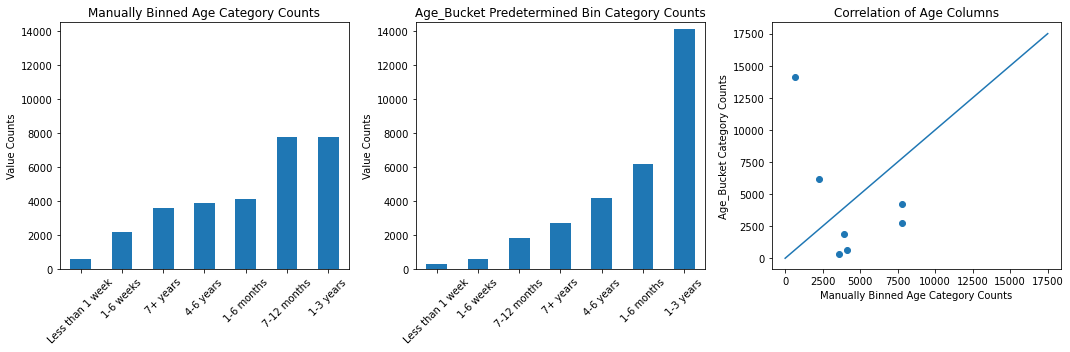

In [119]:
#checking if the columns are correlated
x = np.linspace(-5,17500,100)
y = x

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
binned_age1.value_counts().sort_values().plot(kind='bar')
plt.ylabel('Value Counts')
plt.ylim((0, 14500))
plt.xticks(rotation=45)
plt.title('Manually Binned Age Category Counts')

plt.subplot(1, 3, 2)
shelter_df['Age_Bucket'].value_counts().sort_values().plot(kind='bar')
plt.ylabel('Value Counts')
plt.ylim((0, 14500))
plt.xticks(rotation=45)
plt.title('Age_Bucket Predetermined Bin Category Counts')

plt.subplot(1, 3, 3)
plt.scatter(binned_age1.value_counts().sort_index(), shelter_df['Age_Bucket'].value_counts().sort_index())
plt.xlabel('Manually Binned Age Category Counts')
plt.ylabel('Age_Bucket Category Counts')
plt.title('Correlation of Age Columns')
plt.plot(x,y)

plt.tight_layout()
plt.show()

The bins did not save in the same order even though they were sorted. This is affecting my ability to check for correlation, so I will manually reorder the bins. 

In [120]:
#this is to plot the histograms in the same order
ordered_age_bucket = []
    
for bucket in shelter_df['Age_Bucket']:
    
    if bucket == 'Less than 1 week' :
        ordered_age_bucket.append('1. Less than 1 week')
        
    elif bucket == '1-6 weeks' :
        ordered_age_bucket.append('2. 1-6 weeks')
        
    elif bucket == '1-6 months' :
        ordered_age_bucket.append('3. 1-6 months')
        
    elif bucket == '7-12 months' :
        ordered_age_bucket.append('4. 7-12 months')
        
    elif bucket == '1-3 years':
        ordered_age_bucket.append('5. 1-3 years')
        
    elif bucket == '4-6 years':
        ordered_age_bucket.append('6. 4-6 years')
        
    elif bucket == '7+ years':
        ordered_age_bucket.append('7. 7+ years')
        
    else:
        print('what happened?')
        
ordered_age_bucket = pd.DataFrame(ordered_age_bucket)

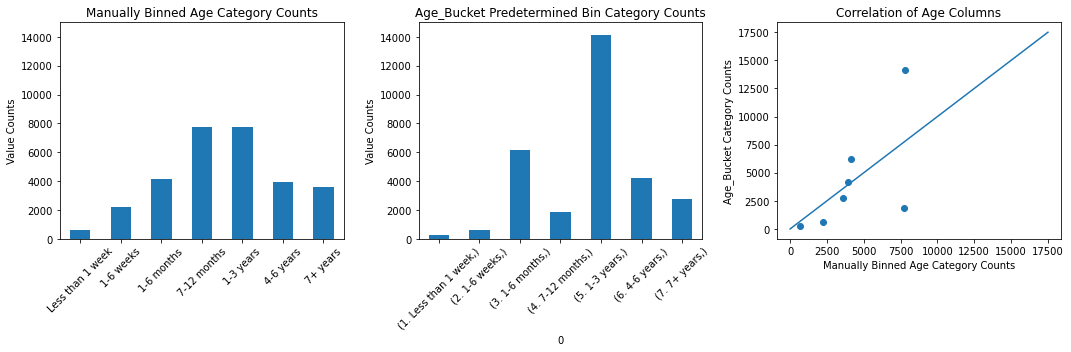

In [121]:
#checking if the columns are correlated
x = np.linspace(-5,17500,100)
y = x

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
binned_age1.value_counts().sort_index().plot(kind='bar')
plt.ylabel('Value Counts')
plt.ylim((0, 15000))
plt.xticks(rotation=45)
plt.title('Manually Binned Age Category Counts')

plt.subplot(1, 3, 2)
ordered_age_bucket.value_counts().sort_index().plot(kind='bar')
plt.ylabel('Value Counts')
plt.ylim((0, 15000))
plt.xticks(rotation=45)
plt.title('Age_Bucket Predetermined Bin Category Counts')

plt.subplot(1, 3, 3)
plt.scatter(binned_age1.value_counts().sort_index(), ordered_age_bucket.value_counts().sort_index())
plt.xlabel('Manually Binned Age Category Counts')
plt.ylabel('Age_Bucket Category Counts')
plt.title('Correlation of Age Columns')
plt.plot(x,y)

plt.tight_layout()
plt.show()

These bins have different distributions, so I can safely keep both for modeling and further EDA. Now I can do the same comparison with the Age upon Outcome column as well. 

In [122]:
shelter_df['Age_upon_Outcome']

Animal ID
A683644     4.0
A676515     3.0
A742953    24.0
A692161     5.0
A720597    24.0
           ... 
A746624    72.0
A746460     2.0
A746689    24.0
A746466     2.0
A746072    24.0
Name: Age_upon_Outcome, Length: 30042, dtype: float64

In [123]:
# I'm going to bin the data in age_in_month to compare it to Age_Bucket
cut_age_outcome = ['Less than 1 week', '1-6 weeks', '1-6 months', '7-12 months', '1-3 years', '4-6 years', '7+ years']
cut_bins2 =[-1, 7/30, 1.5, 6, 12, 36, 72, max(shelter_df['Age_upon_Outcome'])]
binned_age2 = pd.cut(shelter_df['Age_upon_Outcome'], bins=cut_bins2, labels = cut_age_outcome)

In [124]:
binned_age2.isna().sum()

0

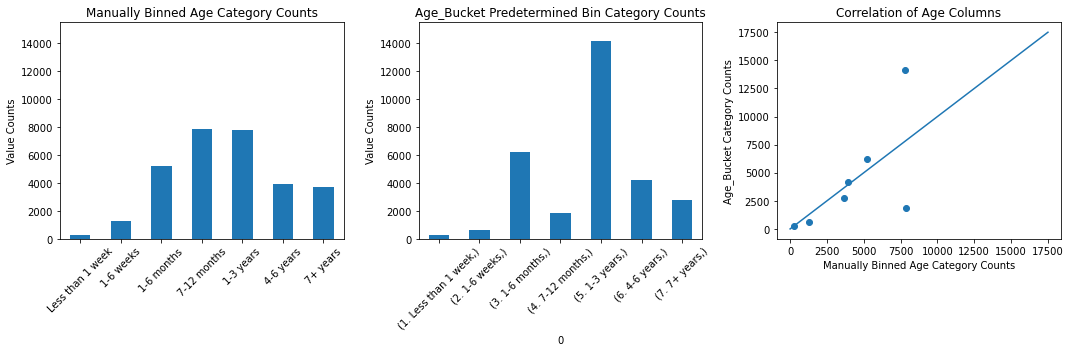

In [125]:
#checking if the next two dates are correlated
x = np.linspace(-5,17500,100)
y = x

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
binned_age2.value_counts().sort_index().plot(kind='bar')
plt.ylabel('Value Counts')
plt.ylim((0, 15500))
plt.xticks(rotation=45)
plt.title('Manually Binned Age Category Counts')

plt.subplot(1, 3, 2)
ordered_age_bucket.value_counts().sort_index().plot(kind='bar')
plt.ylabel('Value Counts')
plt.ylim((0, 15500))
plt.xticks(rotation=45)
plt.title('Age_Bucket Predetermined Bin Category Counts')

plt.subplot(1, 3, 3)
plt.scatter(binned_age2.value_counts().sort_index(), ordered_age_bucket.value_counts().sort_index())
plt.xlabel('Manually Binned Age Category Counts')
plt.ylabel('Age_Bucket Category Counts')
plt.title('Correlation of Age Columns')
plt.plot(x,y)

plt.tight_layout()
plt.show()

Likewise, these distributions are not very similar, so both can be saved to use in building models as well as further EDA. As a sanity check, I will confirm the age and age upon outcome columns are not 1:1 correlated. 

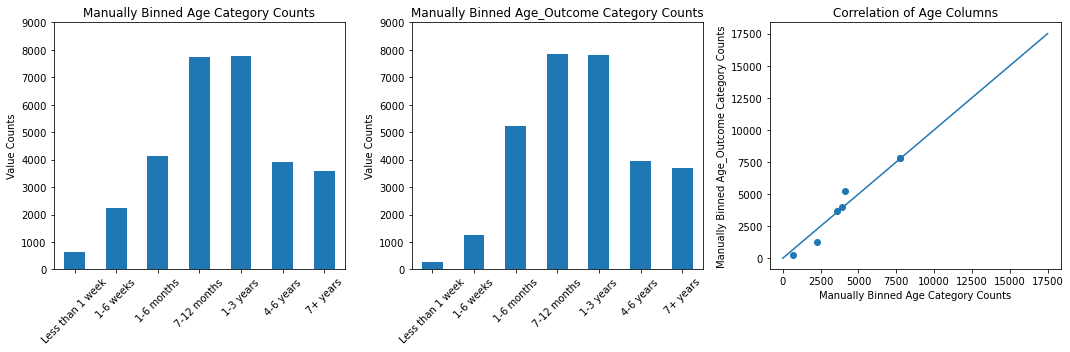

In [126]:
#checking if they're correlated with each other
x = np.linspace(-5,17500,100)
y = x

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
binned_age1.value_counts().sort_index().plot(kind='bar')
plt.ylabel('Value Counts')
plt.ylim((0, 9000))
plt.xticks(rotation=45)
plt.title('Manually Binned Age Category Counts')

plt.subplot(1, 3, 2)
binned_age2.value_counts().sort_index().plot(kind='bar')
plt.ylabel('Value Counts')
plt.ylim((0, 9000))
plt.xticks(rotation=45)
plt.title('Manually Binned Age_Outcome Category Counts')

plt.subplot(1, 3, 3)
plt.scatter(binned_age1.value_counts().sort_index(), binned_age2.value_counts().sort_index())
plt.xlabel('Manually Binned Age Category Counts')
plt.ylabel('Manually Binned Age_Outcome Category Counts')
plt.title('Correlation of Age Columns')
plt.plot(x,y)

plt.tight_layout()
plt.show()

Oddly, the two age columns are more correlated with each other (but 1:1) than with the bucket column. This may be because of the bin categories are a bit ambiguous in the data that came pre-binned. For this reason, I don't feel comfortable dropping any of these columns completely. I will keep the Age_Bucket in the EDA df and the two age in months columns in the shelter df. 

In [127]:
shelter_df.drop('Age_Bucket', axis=1, inplace=True)

In [128]:
shelter_df.columns

Index(['Name_intake', 'DateTime_intake', 'Found_Location', 'Intake_Type',
       'IntakeCondition', 'Sex', 'Age', 'DateTime_outcome', 'Outcome_Type',
       'Outcome_Subtype', 'Sex_upon_Outcome', 'Age_upon_Outcome',
       'gender_intake', 'gender_outcome', 'fixed_intake', 'fixed_outcome',
       'fixed_changed', 'retriever', 'shepherd', 'beagle', 'terrier', 'boxer',
       'poodle', 'rottweiler', 'dachshund', 'chihuahua', 'pit bull',
       'DateTime_length', 'Date of Birth', 'cattle dog', 'collie', 'catahoula',
       'schnauzer', 'husky', 'pyrenees', 'shih tzu', 'pointer', 'bulldog',
       'kelpie', 'black mouth cur', 'hound', 'heeler', 'pinscher', 'maltese',
       'chow', 'pug', 'lhasa apso', 'pomeranian', 'corgi', 'spaniel',
       'blue lacy', 'black', 'white', 'brown', 'tan', 'tricolor', 'brindle',
       'blue', 'red', 'chocolate', 'sable'],
      dtype='object')

Finally, I would like to compare age and date of birth columns. If they are highly correlated, I will drop the DOB column. 

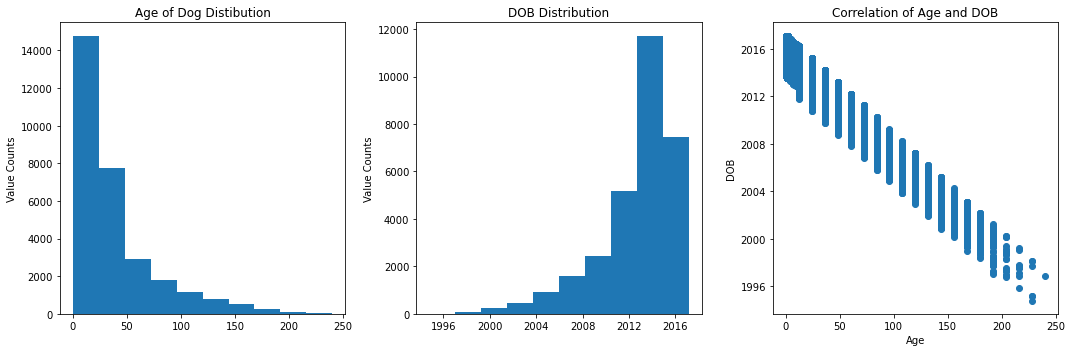

In [129]:
#checking if they're correlated with each other
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(shelter_df['Age'])
plt.ylabel('Value Counts')
#plt.ylim((0, 9000))
plt.title('Age of Dog Distibution')

plt.subplot(1, 3, 2)
plt.hist(shelter_df['Date of Birth'])
plt.ylabel('Value Counts')
#plt.ylim((0, 9000))
plt.title('DOB Distribution')

plt.subplot(1, 3, 3)
plt.scatter(shelter_df['Age'], shelter_df['Date of Birth'])
plt.xlabel('Age')
plt.ylabel('DOB')
plt.title('Correlation of Age and DOB')

plt.tight_layout()
plt.show()

They are not perfectly correlated, but they are correlated enough that I think it would be redundant to include the DOB in the modeling df.

In [130]:
#drop the dob column
shelter_df.drop('Date of Birth', axis=1, inplace=True)

## Fixed Status Columns
<a class="anchor" id="fixed"></a>

There are several columns that identify if a dog has been spayed or neutered. I will sort through these and see if any of them are redundant and how they can be cleaned to used for modeling. 

In [131]:
shelter_df[['fixed_outcome', 'fixed_intake', 'fixed_changed']]

,fixed_outcome,fixed_intake,fixed_changed
Animal ID,,,
A683644,Spayed,Intact,1
A676515,Neutered,Intact,1
A742953,Intact,Intact,0
A692161,Neutered,Intact,1
A720597,Intact,Intact,0
...,...,...,...
A746624,Intact,Intact,0
A746460,Neutered,Intact,1
A746689,Spayed,Spayed,0


The fixed_changed column is already binary so I will change the dtype to int. 

In [132]:
shelter_df['fixed_changed'] = shelter_df['fixed_changed'].astype(int)

In [133]:
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name_intake       24606 non-null  object        
 1   DateTime_intake   30042 non-null  datetime64[ns]
 2   Found_Location    30042 non-null  object        
 3   Intake_Type       30042 non-null  object        
 4   IntakeCondition   30042 non-null  object        
 5   Sex               30041 non-null  object        
 6   Age               30042 non-null  float64       
 7   DateTime_outcome  30042 non-null  datetime64[ns]
 8   Outcome_Type      30041 non-null  object        
 9   Outcome_Subtype   10152 non-null  object        
 10  Sex_upon_Outcome  30040 non-null  object        
 11  Age_upon_Outcome  30042 non-null  float64       
 12  gender_intake     29884 non-null  object        
 13  gender_outcome    29883 non-null  object        
 14  fixed_intake      3

In [134]:
shelter_df[['fixed_outcome', 'fixed_intake']]

,fixed_outcome,fixed_intake
Animal ID,,
A683644,Spayed,Intact
A676515,Neutered,Intact
A742953,Intact,Intact
A692161,Neutered,Intact
A720597,Intact,Intact
...,...,...
A746624,Intact,Intact
A746460,Neutered,Intact
A746689,Spayed,Spayed


Since we have the fixed_intake status and the fixed_changed status, we don't need the fixed_outcome column. It is redundant. 

In [135]:
shelter_df.drop('fixed_outcome', axis=1, inplace=True)

The fixed_intake column is essentially binary right now. It explains that either the dog is fixed or not, but male and female dogs have different surgery types to become fixed, so they use different words for these procedures. Since the type of surgery they have had is irrelevant to this project, I will map these two columns to fixed (1) and note fixed (0).

In [136]:
#What are the possible classes for this column
shelter_df['fixed_intake'].unique()

array(['Intact', 'Neutered', 'Spayed', 'Unknown', nan], dtype=object)

In [137]:
#how many dogs are in the unknown and NaN classes
print(f"There is/are {shelter_df['fixed_intake'].isna().sum()} NaN value(s).")
shelter_df['fixed_intake'].value_counts()

There is/are 1 NaN value(s).


Intact      20100
Neutered     5261
Spayed       4523
Unknown       157
Name: fixed_intake, dtype: int64

Intact will be mapped to 0 because they are not fixed, both neutered and spayed will map to 1 because they are fixed. In the case of unknown, it is safest to assume these dogs are not fixed for practical purposes, so I will map them to 0 also. As for the NaN, I will investigate after the mapping to see if there is any way to fill in that value. 

In [138]:
#mapped the categorical data over to 1: know is fixed and 0: not fixed or unknown
shelter_df['fixed_intake'] = shelter_df['fixed_intake'].map({'Spayed':1, 'Neutered':1, 'Intact':0, 'Unknown':0})

shelter_df['fixed_intake'].unique()

array([ 0.,  1., nan])

In [139]:
shelter_df['fixed_intake'].isna().sum()

1

In [140]:
#filled nan with 0 because same as unknown and changed the colunm from floats to ints
shelter_df['fixed_intake'] = shelter_df['fixed_intake'].fillna(0)
shelter_df['fixed_intake'] = shelter_df['fixed_intake'].astype(int)
shelter_df['fixed_intake'].unique()

array([0, 1])

In [141]:
EDA_shelter_df['fixed_intake'] = shelter_df['fixed_intake']
EDA_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Name_intake         24606 non-null  object        
 1   Found_Location      30042 non-null  object        
 2   Intake_Type         30042 non-null  object        
 3   IntakeCondition     30042 non-null  object        
 4   Outcome_Type        30041 non-null  object        
 5   Outcome_Subtype     10152 non-null  object        
 6   gender_intake       29884 non-null  object        
 7   fixed_changed       30042 non-null  object        
 8   fixed_intake        30042 non-null  int32         
 9   fixed_outcome       30040 non-null  object        
 10  Breed_intake        30042 non-null  object        
 11  Color_intake        30042 non-null  object        
 12  Date of Birth       30042 non-null  datetime64[ns]
 13  Age_Bucket          30042 non-null  object 

In [142]:
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 59 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name_intake       24606 non-null  object        
 1   DateTime_intake   30042 non-null  datetime64[ns]
 2   Found_Location    30042 non-null  object        
 3   Intake_Type       30042 non-null  object        
 4   IntakeCondition   30042 non-null  object        
 5   Sex               30041 non-null  object        
 6   Age               30042 non-null  float64       
 7   DateTime_outcome  30042 non-null  datetime64[ns]
 8   Outcome_Type      30041 non-null  object        
 9   Outcome_Subtype   10152 non-null  object        
 10  Sex_upon_Outcome  30040 non-null  object        
 11  Age_upon_Outcome  30042 non-null  float64       
 12  gender_intake     29884 non-null  object        
 13  gender_outcome    29883 non-null  object        
 14  fixed_intake      3

## Outcome (Adopted) Columns
<a class="anchor" id="adopt"></a>

`Outcome_Type` - is the target variable for this project. I will dig into it and determine how best to convert the data in this column. 

In [143]:
#what does the data look like in this columns
shelter_df['Outcome_Type'].unique()

array(['Adoption', 'Return to Owner', 'Transfer', 'Euthanasia', 'Died',
       'Missing', 'Disposal', 'Rto-Adopt', nan], dtype=object)

In [144]:
#how many dogs are in each class
shelter_df['Outcome_Type'].value_counts()

Adoption           13225
Return to Owner     8306
Transfer            7087
Euthanasia          1282
Died                 112
Missing               10
Rto-Adopt             10
Disposal               9
Name: Outcome_Type, dtype: int64

In [145]:
#are there are NaNs?
shelter_df['Outcome_Type'].isna().sum()

1

In [146]:
#which row has the NaN?
shelter_df[shelter_df['Outcome_Type'].isna()==True]

,Name_intake,DateTime_intake,Found_Location,Intake_Type,IntakeCondition,Sex,Age,DateTime_outcome,Outcome_Type,Outcome_Subtype,...,black,white,brown,tan,tricolor,brindle,blue,red,chocolate,sable
Animal ID,,,,,,,,,,,,,,,,,,,,,
A737705,*Heddy,2016-11-02 20:15:00,1607 Barney in Austin (TX),Stray,Normal,Intact Female,36.0,2016-11-19 16:35:00,NaN,NaN,...,1,1,0,0,0,0,0,0,0,0


This is the same dog that was missing the age on outcome. It's possible that this dog is still at the shelter or the outcome info is missing for some other reasons. Since this one dog will not affect the predictive power of future models and it has several missing columns, I will drop it. 

In [147]:
#all of the rows with outcome status
shelter_df[shelter_df['Outcome_Type'].isna()!=True]

,Name_intake,DateTime_intake,Found_Location,Intake_Type,IntakeCondition,Sex,Age,DateTime_outcome,Outcome_Type,Outcome_Subtype,...,black,white,brown,tan,tricolor,brindle,blue,red,chocolate,sable
Animal ID,,,,,,,,,,,,,,,,,,,,,
A683644,*Zoey,2014-07-13 11:02:00,Austin (TX),Owner Surrender,Nursing,Intact Female,0.93,2014-11-06 10:06:00,Adoption,Foster,...,0,1,1,0,0,0,0,0,0,0
A676515,Rico,2014-04-11 08:45:00,615 E. Wonsley in Austin (TX),Stray,Normal,Intact Male,2.00,2014-04-14 18:38:00,Return to Owner,NaN,...,0,1,1,0,0,0,0,0,0,0
A742953,NaN,2017-01-31 13:30:00,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Intact Male,24.00,2017-02-04 14:17:00,Transfer,Partner,...,0,0,0,0,0,0,0,0,0,1
A692161,George,2014-11-15 15:18:00,Avenue G/42Nd in Austin (TX),Owner Surrender,Normal,Intact Male,5.00,2014-11-21 18:55:00,Adoption,NaN,...,0,1,1,0,0,0,0,0,0,0
A720597,*Franklin,2016-02-12 14:35:00,8413 Danville Dr in Austin (TX),Stray,Injured,Intact Male,24.00,2016-02-19 16:20:00,Transfer,Partner,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A746624,Cuddles,2017-04-05 18:39:00,Aspen Glenn Blvd & Alpine Autumn Dr in Austin ...,Stray,Normal,Intact Female,72.00,2017-04-07 17:42:00,Return to Owner,NaN,...,0,1,0,0,0,0,0,0,0,0
A746460,Spanky,2017-04-03 15:02:00,4858 Yager Ln in Travis (TX),Stray,Normal,Intact Male,2.00,2017-04-07 18:56:00,Adoption,NaN,...,0,1,1,0,0,0,0,0,0,0
A746689,Marylin,2017-04-07 12:36:00,Sweet Leaf And St Patricks in Pflugerville (TX),Stray,Normal,Spayed Female,24.00,2017-04-08 11:32:00,Return to Owner,NaN,...,0,1,0,1,0,0,0,0,0,0


In [148]:
#the new df after dropping that column
shelter_df = shelter_df[shelter_df['Outcome_Type'].isna()!=True]
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30041 entries, A683644 to A746072
Data columns (total 59 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name_intake       24605 non-null  object        
 1   DateTime_intake   30041 non-null  datetime64[ns]
 2   Found_Location    30041 non-null  object        
 3   Intake_Type       30041 non-null  object        
 4   IntakeCondition   30041 non-null  object        
 5   Sex               30040 non-null  object        
 6   Age               30041 non-null  float64       
 7   DateTime_outcome  30041 non-null  datetime64[ns]
 8   Outcome_Type      30041 non-null  object        
 9   Outcome_Subtype   10152 non-null  object        
 10  Sex_upon_Outcome  30040 non-null  object        
 11  Age_upon_Outcome  30041 non-null  float64       
 12  gender_intake     29883 non-null  object        
 13  gender_outcome    29883 non-null  object        
 14  fixed_intake      3

In [149]:
#copy to df to make a more specific target variable category
adopt_partner_shelter_df = shelter_df.copy()

#only keep adopted, transfered or euthanized dogs
adopt_partner_shelter_df = adopt_partner_shelter_df[(adopt_partner_shelter_df['Outcome_Type'] == 'Transfer')
                                                    |(adopt_partner_shelter_df['Outcome_Type'] == 'Adoption')
                                                    |(adopt_partner_shelter_df['Outcome_Type'] == 'Euthanasia')]

In [150]:
#how many dogs are left after dropping the other outcome types
adopt_partner_shelter_df.shape

(21594, 59)

There are around 9000 fewer rows in this df, but this should still be enough data to build a model. Now I will convert the outcome type for the shelter df where adopt is 1 and all other outcomes are 0. 

In [151]:
#are there any NaNs
shelter_df['Outcome_Type'].isna().sum()

0

In [152]:
#are there any NaNs
adopt_partner_shelter_df['Outcome_Type'].isna().sum()

0

In [153]:
#convert outcome to binary
shelter_df['Outcome_Type'] = np.where(shelter_df['Outcome_Type']=='Adoption', 1, 0)
adopt_partner_shelter_df['Outcome_Type'] = np.where(adopt_partner_shelter_df['Outcome_Type']=='Adoption', 1, 0)

#check to make sure there are no NaNs after the mapping
print(shelter_df['Outcome_Type'].isna().sum())
print(adopt_partner_shelter_df['Outcome_Type'].isna().sum())

0
0


In [154]:
#does the target variable column make sense? 
shelter_df['Outcome_Type'].describe()

count    30041.000000
mean         0.440232
std          0.496423
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Outcome_Type, dtype: float64

In [155]:
#does the target variable column make siense?
adopt_partner_shelter_df['Outcome_Type'].describe()

count    21594.000000
mean         0.612439
std          0.487205
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Outcome_Type, dtype: float64

Both data frames now have a binary target variable column based on the criteria mentioned above. The distributions are logical for the dataset I'm working with and there are no NaNs in the column. Now I will convert the columns to int values. I will not include this in the EDA df because it already has the outcome types that can be grouped on Tableau. 

In [156]:
#change the colunm  to ints
shelter_df['Outcome_Type'] = shelter_df['Outcome_Type'].astype(int)
adopt_partner_shelter_df['Outcome_Type'] = adopt_partner_shelter_df['Outcome_Type'].astype(int)
print(shelter_df['Outcome_Type'].unique())
adopt_partner_shelter_df['Outcome_Type'].unique()

[1 0]


array([1, 0])

For the `Outcome_Subtype` column I will take a look at the data and determine what I should do to clean it.

In [157]:
#what does the data look like
shelter_df['Outcome_Subtype'].unique()

array(['Foster', nan, 'Partner', 'Aggressive', 'Suffering', 'Offsite',
       'Behavior', 'In Kennel', 'Medical', 'Rabies Risk',
       'Possible Theft', 'At Vet', 'In Foster', 'In Surgery',
       'Court/Investigation', 'Enroute', 'Barn'], dtype=object)

In [158]:
#what is the distribution
shelter_df['Outcome_Subtype'].value_counts()

Partner                7086
Foster                 1519
Suffering               608
Aggressive              411
Offsite                 161
Behavior                124
In Kennel                71
Rabies Risk              71
Medical                  53
In Foster                17
At Vet                   11
Court/Investigation      11
In Surgery                4
Possible Theft            2
Enroute                   2
Barn                      1
Name: Outcome_Subtype, dtype: int64

In [159]:
#are these categories mutually exclusive among the outcome types
shelter_df.groupby(['Outcome_Type', 'Outcome_Subtype'])['Outcome_Type'].count()

Outcome_Type  Outcome_Subtype    
0             Aggressive              411
              At Vet                   11
              Barn                      1
              Behavior                124
              Court/Investigation      11
              Enroute                   2
              In Foster                17
              In Kennel                71
              In Surgery                4
              Medical                  53
              Partner                7086
              Possible Theft            2
              Rabies Risk              71
              Suffering               608
1             Foster                 1519
              Offsite                 161
Name: Outcome_Type, dtype: int64

In [160]:
#how many null values are there
shelter_df['Outcome_Subtype'].isna().sum()

19889

Considering there are so many NaNs and the 2 largest subtypes Partner and Foster are indicative of their outcome type, I feel comfortable deleting this column all together. 

In [161]:
#drop the subtype column
shelter_df.drop('Outcome_Subtype', axis=1, inplace=True)
adopt_partner_shelter_df.drop('Outcome_Subtype', axis=1, inplace=True)
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30041 entries, A683644 to A746072
Data columns (total 58 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name_intake       24605 non-null  object        
 1   DateTime_intake   30041 non-null  datetime64[ns]
 2   Found_Location    30041 non-null  object        
 3   Intake_Type       30041 non-null  object        
 4   IntakeCondition   30041 non-null  object        
 5   Sex               30040 non-null  object        
 6   Age               30041 non-null  float64       
 7   DateTime_outcome  30041 non-null  datetime64[ns]
 8   Outcome_Type      30041 non-null  int32         
 9   Sex_upon_Outcome  30040 non-null  object        
 10  Age_upon_Outcome  30041 non-null  float64       
 11  gender_intake     29883 non-null  object        
 12  gender_outcome    29883 non-null  object        
 13  fixed_intake      30041 non-null  int32         
 14  fixed_changed     3

Not that the outcome columns are cleaned up, I will move onto the gender and sex columns. 

# Gender and Sex Columns
<a class="anchor" id="sex"></a>

With just a few more columns that need to be cleaned, I would like to compare the `gender_intake` and `gender_outcome` columns. Logically speaking, there shouldn't be a change in gender at the shelter, so I will look into why these columns were not considered duplicates. I will also look into the 'Sex' column because this should be the same as gender for dogs. 

In [162]:
#what do these columns look like
shelter_df[['gender_intake', 'gender_outcome', 'Sex', 'Sex_upon_Outcome']]

,gender_intake,gender_outcome,Sex,Sex_upon_Outcome
Animal ID,,,,
A683644,Female,Female,Intact Female,Spayed Female
A676515,Male,Male,Intact Male,Neutered Male
A742953,Male,Male,Intact Male,Intact Male
A692161,Male,Male,Intact Male,Neutered Male
A720597,Male,Male,Intact Male,Intact Male
...,...,...,...,...
A746624,Female,Female,Intact Female,Intact Female
A746460,Male,Male,Intact Male,Neutered Male
A746689,Female,Female,Spayed Female,Spayed Female


In [163]:
#what are the classes
shelter_df['Sex'].unique()

array(['Intact Female', 'Intact Male', 'Neutered Male', 'Spayed Female',
       'Unknown', nan], dtype=object)

In [164]:
#how many NaNs are there?
shelter_df['Sex'].isna().sum()

1

In [165]:
#which row has the nan value, can other columns help us fill it in?
shelter_df[shelter_df['Sex'].isna()==True]

,Name_intake,DateTime_intake,Found_Location,Intake_Type,IntakeCondition,Sex,Age,DateTime_outcome,Outcome_Type,Sex_upon_Outcome,...,black,white,brown,tan,tricolor,brindle,blue,red,chocolate,sable
Animal ID,,,,,,,,,,,,,,,,,,,,,
A667395,Diego,2013-11-17 13:15:00,Pflugerville (TX),Owner Surrender,Normal,NaN,84.0,2013-11-27 16:11:00,0,NaN,...,0,0,1,0,0,0,0,0,0,0


In [166]:
#which row has the nan value, can other columns help us fill it in?
shelter_df[shelter_df['Sex'].isna()==True][['gender_intake', 'gender_outcome', 'Sex', 'Sex_upon_Outcome']]

,gender_intake,gender_outcome,Sex,Sex_upon_Outcome
Animal ID,,,,
A667395,NaN,NaN,NaN,NaN


It looks like this row will need to be dropped because there are a lot of missing cells. 

In [167]:
#what classes are there?
shelter_df['Sex_upon_Outcome'].unique()

array(['Spayed Female', 'Neutered Male', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [168]:
#how many NaNs are there?
shelter_df['Sex_upon_Outcome'].isna().sum()

1

In [169]:
shelter_df[shelter_df['Sex_upon_Outcome'].isna()==True].T

Animal ID,A667395
Name_intake,Diego
DateTime_intake,2013-11-17 13:15:00
Found_Location,Pflugerville (TX)
Intake_Type,Owner Surrender
IntakeCondition,Normal
Sex,NaN
Age,84.0
DateTime_outcome,2013-11-27 16:11:00
Outcome_Type,0
Sex_upon_Outcome,NaN


In [170]:
shelter_df = shelter_df[shelter_df['Sex_upon_Outcome'].isna()!=True]
adopt_partner_shelter_df = adopt_partner_shelter_df[adopt_partner_shelter_df['Sex_upon_Outcome'].isna()!=True]

The data from `Sex` and `Sex_upon_Outcome` is already encapsulated in the gender columns and fixed columns discussed previously, so I will drop them from the shelter df and adopt transfer df too. 

In [171]:
shelter_df.drop(['Sex', 'Sex_upon_Outcome'], axis=1, inplace=True)
adopt_partner_shelter_df.drop(['Sex', 'Sex_upon_Outcome'], axis=1, inplace=True)

Now I will compare the gender columns and convert one of them to binary where male is 1 and female is 0. I will drop which ever column has less data. 

In [172]:
#what data is in this column?
print(shelter_df['gender_intake'].value_counts())
shelter_df['gender_intake'].isna().sum()

Male      16041
Female    13842
Name: gender_intake, dtype: int64


157

In [173]:
#what data is in this column
print(shelter_df['gender_outcome'].value_counts())
shelter_df['gender_outcome'].isna().sum()

Male      16041
Female    13842
Name: gender_outcome, dtype: int64


157

In [174]:
f"The null values are {round(170/(16622+14340+170)*100, 2)}% of the data."

'The null values are 0.55% of the data.'

Both columns have the same number of male and female dogs and both have 170 null values. I will probably drop the outcome column and then drop the rows will null values since it is only 0.55% of the data, but first I will look into possible reason why these might be NaNs. 

In [175]:
#does it have to do with intake_type?
shelter_df[shelter_df['gender_intake'].isna()].groupby('Intake_Type')['DateTime_intake'].count()
#5 euthanasia, 44 owner surrender, 3 public assist, 119 stray

Intake_Type
Euthanasia Request      5
Owner Surrender        31
Public Assist           3
Stray                 118
Name: DateTime_intake, dtype: int64

In [176]:
#is does it have to do with intake condition?
shelter_df[shelter_df['gender_intake'].isna()].groupby('IntakeCondition')['DateTime_intake'].count()
#3 aged, 14 injured, 80 noral, 49 nursing, 25 sick

IntakeCondition
Aged        3
Injured    14
Normal     79
Nursing    48
Sick       13
Name: DateTime_intake, dtype: int64

In [177]:
#is it related to outcome type?
shelter_df[shelter_df['gender_intake'].isna()].groupby('Outcome_Type')['DateTime_intake'].count()
# 0 adopted

Outcome_Type
0    157
Name: DateTime_intake, dtype: int64

In [178]:
#does it have to do with their fixed status?
shelter_df[shelter_df['gender_intake'].isna()].groupby('fixed_intake')['DateTime_intake'].count()
# 0 fixed

fixed_intake
0    157
Name: DateTime_intake, dtype: int64

In [179]:
#is it related to the 'fixed changed' status?
shelter_df[shelter_df['gender_intake'].isna()].groupby('fixed_changed')['DateTime_intake'].count()
#3 0 changed

fixed_changed
0    157
Name: DateTime_intake, dtype: int64

In [180]:
#does it have to do with their age?
shelter_df[shelter_df['gender_intake'].isna()].groupby('Age')['DateTime_intake'].count()

Age
0.00      26
0.03      13
0.07      13
0.10       4
0.13       1
0.20      14
0.23      24
0.47       7
0.70       2
0.93       6
1.00       7
2.00       5
3.00       2
4.00       2
6.00       4
9.00       1
12.00      7
24.00      2
36.00      4
48.00      3
60.00      1
96.00      1
108.00     2
120.00     1
132.00     1
144.00     1
156.00     1
168.00     1
192.00     1
Name: DateTime_intake, dtype: int64

They are all not adopted, not fixed dogs, but there are lots of dogs in those categories with gender inputs, so it is not clear why thy are NaN. Therefore I will drop them from both data frames. 

In [181]:
#only keep the columns with gender info
shelter_df = shelter_df[shelter_df['gender_intake'].isna()!=True]
adopt_partner_shelter_df = adopt_partner_shelter_df[adopt_partner_shelter_df['gender_intake'].isna()!=True]

In [182]:
#are there any NaNs left
print(shelter_df['gender_intake'].isna().sum())
adopt_partner_shelter_df['gender_intake'].isna().sum()

0


0

In [183]:
#map genders 1 for male, 0 for female
shelter_df['gender_intake'] = shelter_df['gender_intake'].map({'Male':1, 'Female':0})
adopt_partner_shelter_df['gender_intake'] = adopt_partner_shelter_df['gender_intake'].map({'Male':1, 'Female':0})

In [184]:
print(shelter_df['gender_intake'].unique())
adopt_partner_shelter_df['gender_intake'].unique()

[0 1]


array([0, 1], dtype=int64)

In [185]:
# so let's drop gender_outcome since it's redundant
shelter_df.drop(['gender_outcome'], axis=1, inplace=True)
adopt_partner_shelter_df.drop(['gender_outcome'], axis=1, inplace=True)

In [186]:
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29883 entries, A683644 to A746072
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name_intake       24586 non-null  object        
 1   DateTime_intake   29883 non-null  datetime64[ns]
 2   Found_Location    29883 non-null  object        
 3   Intake_Type       29883 non-null  object        
 4   IntakeCondition   29883 non-null  object        
 5   Age               29883 non-null  float64       
 6   DateTime_outcome  29883 non-null  datetime64[ns]
 7   Outcome_Type      29883 non-null  int32         
 8   Age_upon_Outcome  29883 non-null  float64       
 9   gender_intake     29883 non-null  int64         
 10  fixed_intake      29883 non-null  int32         
 11  fixed_changed     29883 non-null  int32         
 12  retriever         29883 non-null  int32         
 13  shepherd          29883 non-null  int32         
 14  beagle            2

Now that the 4 sex and gender columns have been reduced to one, there are only a few more columns that need to be cleaned. I will look at the intake condition columns now. 

## Intake Condition Columns
<a class="anchor" id="intake"></a>

Similar to the outcome conditions, there are two intake condition columns. One is the general intake condition and the second is the subtype to give more detail. I will look into these and see if they are redundant and/or if they can be represented in numerical values. 

In [187]:
#what does this column look like?
shelter_df['IntakeCondition'].unique()
#2 major categories: normal - 1 or not - 0

array(['Nursing', 'Normal', 'Injured', 'Sick', 'Aged', 'Other',
       'Pregnant', 'Feral'], dtype=object)

In [188]:
#what is the distribution
shelter_df['IntakeCondition'].value_counts()

Normal      27074
Injured      1296
Sick          785
Nursing       405
Aged          213
Other          74
Pregnant       29
Feral           7
Name: IntakeCondition, dtype: int64

The 'Normal' intake condition is significantly larger than any of the other classes. It seems like converting this column into normal (1) versus not normal (0) intake would make the most sense. 

In [189]:
#turn this column into binary
shelter_df['IntakeCondition'] = np.where(shelter_df['IntakeCondition']== 'Normal', 1, 0)
adopt_partner_shelter_df['IntakeCondition'] = np.where(adopt_partner_shelter_df['IntakeCondition'] == 'Normal', 1, 0)

In [190]:
shelter_df['IntakeCondition'].unique()

array([0, 1])

In [191]:
#set values to int
shelter_df['IntakeCondition'] = shelter_df['IntakeCondition'].astype(int)
adopt_partner_shelter_df['IntakeCondition'] = adopt_partner_shelter_df['IntakeCondition'].astype(int)

Now that the general intake condition is cleaned, I will now consider the subtype and determine a plan to clean this column. 

In [192]:
#what does this column look like?
shelter_df['Intake_Type'].unique()
# stray:1 or not stray:0 seem to be the cases

array(['Owner Surrender', 'Stray', 'Public Assist', 'Euthanasia Request'],
      dtype=object)

In [193]:
#What does the distribution look like?
shelter_df['Intake_Type'].value_counts()

Stray                 22316
Owner Surrender        4904
Public Assist          2496
Euthanasia Request      167
Name: Intake_Type, dtype: int64

The stray category is significantly larger than the other classes. I will likely make this column binary with stray (1) and not stray (0) intake, but first I would like to compare it with the IntakeCondition column to make sure this is not redundant. 

In [194]:
#grouping the two intake condition columns to see if there is a pattern
shelter_df.groupby(['IntakeCondition', 'Intake_Type'])['DateTime_length'].count()

IntakeCondition  Intake_Type       
0                Euthanasia Request      100
                 Owner Surrender         473
                 Public Assist           154
                 Stray                  2082
1                Euthanasia Request       67
                 Owner Surrender        4431
                 Public Assist          2342
                 Stray                 20234
Name: DateTime_length, dtype: int64

There doesn't seem to be a clear distinction between normal intake and stray or note, so I will go ahead and clean this column accordingly. 

In [195]:
#change this column to stray vs. not stray
shelter_df['Intake_Type'] = np.where(shelter_df['Intake_Type']== 'Stray',1, 0)
adopt_partner_shelter_df['Intake_Type'] = np.where(adopt_partner_shelter_df['Intake_Type'] == 'Stray', 1, 0)

In [196]:
#change the binary to into type
shelter_df['Intake_Type'] = shelter_df['Intake_Type'].astype(int)
adopt_partner_shelter_df['Intake_Type'] = adopt_partner_shelter_df['Intake_Type'].astype(int)

Now that the intake condition columns are cleaned and added to the two modeling data frames, I will also add it to the EDA df. 

In [197]:
#adding the intake columns to EDA df
EDA_shelter_df[['bi_intake_condition', 'bi_intake_type']] = shelter_df[['IntakeCondition', 'Intake_Type']]
EDA_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Name_intake          24606 non-null  object        
 1   Found_Location       30042 non-null  object        
 2   Intake_Type          30042 non-null  object        
 3   IntakeCondition      30042 non-null  object        
 4   Outcome_Type         30041 non-null  object        
 5   Outcome_Subtype      10152 non-null  object        
 6   gender_intake        29884 non-null  object        
 7   fixed_changed        30042 non-null  object        
 8   fixed_intake         30042 non-null  int32         
 9   fixed_outcome        30040 non-null  object        
 10  Breed_intake         30042 non-null  object        
 11  Color_intake         30042 non-null  object        
 12  Date of Birth        30042 non-null  datetime64[ns]
 13  Age_Bucket           30042 n

In [198]:
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29883 entries, A683644 to A746072
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name_intake       24586 non-null  object        
 1   DateTime_intake   29883 non-null  datetime64[ns]
 2   Found_Location    29883 non-null  object        
 3   Intake_Type       29883 non-null  int32         
 4   IntakeCondition   29883 non-null  int32         
 5   Age               29883 non-null  float64       
 6   DateTime_outcome  29883 non-null  datetime64[ns]
 7   Outcome_Type      29883 non-null  int32         
 8   Age_upon_Outcome  29883 non-null  float64       
 9   gender_intake     29883 non-null  int64         
 10  fixed_intake      29883 non-null  int32         
 11  fixed_changed     29883 non-null  int32         
 12  retriever         29883 non-null  int32         
 13  shepherd          29883 non-null  int32         
 14  beagle            2

It looks like the intake conditions are all cleared up and I only have the location column noting where the dog was rescued from as well as their names left. I will look into these quickly, but both are likely to be dropped because they are not strongly associated with if an animal will be adopted or not. 

In [199]:
#how many unique locations are there
pd.DataFrame(shelter_df['Found_Location'].unique())

,0
0,Austin (TX)
1,615 E. Wonsley in Austin (TX)
2,S Hwy 183 And Thompson Lane in Austin (TX)
3,Avenue G/42Nd in Austin (TX)
4,8413 Danville Dr in Austin (TX)
...,...
17075,Cuernevaca & Bee Caves in Austin (TX)
17076,3426 Greystone Dr in Austin (TX)
17077,Aspen Glenn Blvd & Alpine Autumn Dr in Austin ...
17078,Sweet Leaf And St Patricks in Pflugerville (TX)


In [200]:
#what is the distribution amongst these locations?
shelter_df['Found_Location'].value_counts()

Austin (TX)                                           5108
Travis (TX)                                            374
7201 Levander Loop in Austin (TX)                      201
Outside Jurisdiction                                   189
Del Valle (TX)                                         164
                                                      ... 
Roseborough Dr And Running Water Dr in Austin (TX)       1
6506 Decker Ln in Austin (TX)                            1
6803 Dorchester in Austin (TX)                           1
5434 Walknut Grove Drive in Austin (TX)                  1
9318 Ih 35 in Austin (TX)                                1
Name: Found_Location, Length: 17080, dtype: int64

In [201]:
#Are there any null values?
shelter_df['Found_Location'].isna().sum()

0

The vast majority of dogs were noted as being found in Austin, TX which is already obvious, so I feel safe dropping this column. 

In [202]:
#drop the location column
shelter_df.drop('Found_Location', axis=1, inplace=True)
adopt_partner_shelter_df.drop('Found_Location', axis=1, inplace=True)

Now I will take a look at the name column.

In [203]:
#how many unique names are there?
pd.DataFrame(shelter_df['Name_intake'].unique())

,0
0,*Zoey
1,Rico
2,NaN
3,George
4,*Franklin
...,...
8749,Boi
8750,Auryn
8751,Georgi
8752,Marylin


In [204]:
#how are the names distributed?
shelter_df['Name_intake'].value_counts()

Bella           190
Max             180
Rocky           144
Princess        133
Daisy           131
               ... 
D.O.G             1
*Kisa             1
Mortakai          1
Delia             1
Wilson Fitzg      1
Name: Name_intake, Length: 8753, dtype: int64

In [205]:
#are there any null values?
shelter_df['Name_intake'].isna().sum()

5297

There are only a few dogs with the same name and quite a lot of null values, so I will drop this column, but for the sake of EDA, I will clean it up a little for the EDA df.

In [206]:
EDA_shelter_df['Name_intake'] = EDA_shelter_df['Name_intake'].astype(str)

In [207]:
for i, name in enumerate(EDA_shelter_df['Name_intake']):
    EDA_shelter_df['Name_intake'][i] = re.sub(rf'[*]', '', name)

for i, name in enumerate(EDA_shelter_df['Name_intake']):
    EDA_shelter_df['Name_intake'][i] = re.sub(rf'[^a-zA-Z0-9]+', '', name)
    
# printing result
EDA_shelter_df['Name_intake']

Animal ID
A683644           Zoey
A676515           Rico
A742953            nan
A692161         George
A720597       Franklin
              ...     
A746624        Cuddles
A746460         Spanky
A746689        Marylin
A746466    WilsonFitzg
A746072            Ace
Name: Name_intake, Length: 30042, dtype: object

In [208]:
def onlySpecialCharacters(df):
    
    num_special_names = 0
    # Regex to check if a string contains
    # only special characters
    regex = "[^a-zA-Z0-9]+"
 
    # Compile the ReGex
    p=re.compile(regex)
    
    for name in df:
        # If the string is empty
        # then print No
        if(len(name) == 0):
            pass

        # Print Yes If the string matches
        # with the Regex
        if(re.search(p, name)):
            num_special_names +=1
    
    return num_special_names
# https://www.geeksforgeeks.org/check-if-a-string-consists-only-of-special-characters/

In [209]:
onlySpecialCharacters(EDA_shelter_df['Name_intake'])
#no special charecter names remain

0

Then I will drop this column from the dfs

In [210]:
#drop the name column
shelter_df.drop('Name_intake', axis=1, inplace=True)
adopt_partner_shelter_df.drop('Name_intake', axis=1, inplace=True)

In [211]:
#Check that everything is numeric values now
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29883 entries, A683644 to A746072
Data columns (total 53 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateTime_intake   29883 non-null  datetime64[ns]
 1   Intake_Type       29883 non-null  int32         
 2   IntakeCondition   29883 non-null  int32         
 3   Age               29883 non-null  float64       
 4   DateTime_outcome  29883 non-null  datetime64[ns]
 5   Outcome_Type      29883 non-null  int32         
 6   Age_upon_Outcome  29883 non-null  float64       
 7   gender_intake     29883 non-null  int64         
 8   fixed_intake      29883 non-null  int32         
 9   fixed_changed     29883 non-null  int32         
 10  retriever         29883 non-null  int32         
 11  shepherd          29883 non-null  int32         
 12  beagle            29883 non-null  int32         
 13  terrier           29883 non-null  int32         
 14  boxer             2

In [212]:
EDA_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30042 entries, A683644 to A746072
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Name_intake          30042 non-null  object        
 1   Found_Location       30042 non-null  object        
 2   Intake_Type          30042 non-null  object        
 3   IntakeCondition      30042 non-null  object        
 4   Outcome_Type         30041 non-null  object        
 5   Outcome_Subtype      10152 non-null  object        
 6   gender_intake        29884 non-null  object        
 7   fixed_changed        30042 non-null  object        
 8   fixed_intake         30042 non-null  int32         
 9   fixed_outcome        30040 non-null  object        
 10  Breed_intake         30042 non-null  object        
 11  Color_intake         30042 non-null  object        
 12  Date of Birth        30042 non-null  datetime64[ns]
 13  Age_Bucket           30042 n

## Split Date Columns
<a class="anchor" id="split"></a>

The DateTime format is useful for Tableau and EDA, but not for modeling, so I will separate them into intake/outcome day, month, and year.

In [213]:
#spliting up the outcome dates for shelter df
shelter_df['outcome_day'] = shelter_df['DateTime_outcome'].dt.day
shelter_df['outcome_month'] = shelter_df['DateTime_outcome'].dt.month
shelter_df['outcome_year'] = shelter_df['DateTime_outcome'].dt.year

#and the same for adopt partner df
adopt_partner_shelter_df['outcome_day'] = adopt_partner_shelter_df['DateTime_outcome'].dt.day
adopt_partner_shelter_df['outcome_month'] = adopt_partner_shelter_df['DateTime_outcome'].dt.month
adopt_partner_shelter_df['outcome_year'] = adopt_partner_shelter_df['DateTime_outcome'].dt.year

In [214]:
#drop the date columns that ate in DateTime format
shelter_df.drop('DateTime_outcome', axis = 1, inplace = True)
adopt_partner_shelter_df.drop('DateTime_outcome', axis = 1, inplace = True)

In [215]:
#do the same for intake
shelter_df['intake_day'] = shelter_df['DateTime_intake'].dt.day
shelter_df['intake_month'] = shelter_df['DateTime_intake'].dt.month
shelter_df['intake_year'] = shelter_df['DateTime_intake'].dt.year

adopt_partner_shelter_df['intake_day'] = adopt_partner_shelter_df['DateTime_intake'].dt.day
adopt_partner_shelter_df['intake_month'] = adopt_partner_shelter_df['DateTime_intake'].dt.month
adopt_partner_shelter_df['intake_year'] = adopt_partner_shelter_df['DateTime_intake'].dt.year

In [216]:
#drop these DateTime columns too
shelter_df.drop('DateTime_intake', axis = 1, inplace = True)
adopt_partner_shelter_df.drop('DateTime_intake',axis= 1, inplace=True)

In [217]:
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29883 entries, A683644 to A746072
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Intake_Type       29883 non-null  int32  
 1   IntakeCondition   29883 non-null  int32  
 2   Age               29883 non-null  float64
 3   Outcome_Type      29883 non-null  int32  
 4   Age_upon_Outcome  29883 non-null  float64
 5   gender_intake     29883 non-null  int64  
 6   fixed_intake      29883 non-null  int32  
 7   fixed_changed     29883 non-null  int32  
 8   retriever         29883 non-null  int32  
 9   shepherd          29883 non-null  int32  
 10  beagle            29883 non-null  int32  
 11  terrier           29883 non-null  int32  
 12  boxer             29883 non-null  int32  
 13  poodle            29883 non-null  int32  
 14  rottweiler        29883 non-null  int32  
 15  dachshund         29883 non-null  int32  
 16  chihuahua         29883 non-null  int

That was straight forward and now there are 3 rows to represent the intake date and the outcome date. Now I will check if there are any rogue null values that need to be addressed.

In [218]:
print(shelter_df.isna().sum().head(50))
print(shelter_df.isna().sum().tail(6))
#only have nulls in gender_intake and they were random and 0.5%, so I feel confident dropping them

Intake_Type         0
IntakeCondition     0
Age                 0
Outcome_Type        0
Age_upon_Outcome    0
gender_intake       0
fixed_intake        0
fixed_changed       0
retriever           0
shepherd            0
beagle              0
terrier             0
boxer               0
poodle              0
rottweiler          0
dachshund           0
chihuahua           0
pit bull            0
DateTime_length     0
cattle dog          0
collie              0
catahoula           0
schnauzer           0
husky               0
pyrenees            0
shih tzu            0
pointer             0
bulldog             0
kelpie              0
black mouth cur     0
hound               0
heeler              0
pinscher            0
maltese             0
chow                0
pug                 0
lhasa apso          0
pomeranian          0
corgi               0
spaniel             0
blue lacy           0
black               0
white               0
brown               0
tan                 0
tricolor  

# Rename Columns
<a class="anchor" id="rename"></a>

Now that all of the columns are numeric and ready for modeling, I can rename them so they follow a similar convention. 

In [219]:
#which columns need to be renamed?
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29883 entries, A683644 to A746072
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Intake_Type       29883 non-null  int32  
 1   IntakeCondition   29883 non-null  int32  
 2   Age               29883 non-null  float64
 3   Outcome_Type      29883 non-null  int32  
 4   Age_upon_Outcome  29883 non-null  float64
 5   gender_intake     29883 non-null  int64  
 6   fixed_intake      29883 non-null  int32  
 7   fixed_changed     29883 non-null  int32  
 8   retriever         29883 non-null  int32  
 9   shepherd          29883 non-null  int32  
 10  beagle            29883 non-null  int32  
 11  terrier           29883 non-null  int32  
 12  boxer             29883 non-null  int32  
 13  poodle            29883 non-null  int32  
 14  rottweiler        29883 non-null  int32  
 15  dachshund         29883 non-null  int32  
 16  chihuahua         29883 non-null  int

In [220]:
 #rename the columns with caps
shelter_df.rename(columns = {'Intake_Type':'stray', 'IntakeCondition':'normal_intake', 'Age':'age_in_months_intake',
                              'Outcome_Type':'adopted', 'Age_upon_Outcome': 'age_in_months_outcome', 
                              'gender_intake':'sex', 'DateTime_length':'length_of_stay'}, inplace = True)

In [221]:
#confirm they were renamed properly and didn't miss anything
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29883 entries, A683644 to A746072
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stray                  29883 non-null  int32  
 1   normal_intake          29883 non-null  int32  
 2   age_in_months_intake   29883 non-null  float64
 3   adopted                29883 non-null  int32  
 4   age_in_months_outcome  29883 non-null  float64
 5   sex                    29883 non-null  int64  
 6   fixed_intake           29883 non-null  int32  
 7   fixed_changed          29883 non-null  int32  
 8   retriever              29883 non-null  int32  
 9   shepherd               29883 non-null  int32  
 10  beagle                 29883 non-null  int32  
 11  terrier                29883 non-null  int32  
 12  boxer                  29883 non-null  int32  
 13  poodle                 29883 non-null  int32  
 14  rottweiler             29883 non-null  int32  
 15 

The columns in shelter_df have more accurate names now. So I will focus on changing ints to int8 to save on storage. 

In [222]:
#which columns can be reduced to int8?
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29883 entries, A683644 to A746072
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stray                  29883 non-null  int32  
 1   normal_intake          29883 non-null  int32  
 2   age_in_months_intake   29883 non-null  float64
 3   adopted                29883 non-null  int32  
 4   age_in_months_outcome  29883 non-null  float64
 5   sex                    29883 non-null  int64  
 6   fixed_intake           29883 non-null  int32  
 7   fixed_changed          29883 non-null  int32  
 8   retriever              29883 non-null  int32  
 9   shepherd               29883 non-null  int32  
 10  beagle                 29883 non-null  int32  
 11  terrier                29883 non-null  int32  
 12  boxer                  29883 non-null  int32  
 13  poodle                 29883 non-null  int32  
 14  rottweiler             29883 non-null  int32  
 15 

In [223]:
for col in shelter_df[['stray', 'normal_intake', 'adopted', 'sex', 'fixed_intake', 'fixed_changed', 'retriever', 
                       'shepherd', 'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 'chihuahua', 
                       'pit bull', 'length_of_stay', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 
                       'pyrenees', 'shih tzu', 'pointer', 'bulldog', 'kelpie', 'black mouth cur', 'hound', 'heeler', 
                       'pinscher', 'maltese', 'chow', 'pug', 'lhasa apso', 'pomeranian', 'corgi', 'spaniel', 
                       'blue lacy', 'black', 'white', 'brown', 'tan', 'tricolor', 'brindle', 'blue', 'red', 
                       'chocolate', 'sable', 'outcome_day', 'outcome_month', 'outcome_year', 'intake_day', 
                       'intake_month', 'intake_year'  ]].columns:
    shelter_df[col] = shelter_df[col].astype(np.int8)

In [224]:
#did it work?
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29883 entries, A683644 to A746072
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stray                  29883 non-null  int8   
 1   normal_intake          29883 non-null  int8   
 2   age_in_months_intake   29883 non-null  float64
 3   adopted                29883 non-null  int8   
 4   age_in_months_outcome  29883 non-null  float64
 5   sex                    29883 non-null  int8   
 6   fixed_intake           29883 non-null  int8   
 7   fixed_changed          29883 non-null  int8   
 8   retriever              29883 non-null  int8   
 9   shepherd               29883 non-null  int8   
 10  beagle                 29883 non-null  int8   
 11  terrier                29883 non-null  int8   
 12  boxer                  29883 non-null  int8   
 13  poodle                 29883 non-null  int8   
 14  rottweiler             29883 non-null  int8   
 15 

I successfully changed the names of the columns and converted the dtype to int8 for all columns that apply. I will now do the same for the adopt partner df. 

In [225]:
#which columns need to be renamed?
adopt_partner_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21462 entries, A683644 to A746072
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Intake_Type       21462 non-null  int32  
 1   IntakeCondition   21462 non-null  int32  
 2   Age               21462 non-null  float64
 3   Outcome_Type      21462 non-null  int32  
 4   Age_upon_Outcome  21462 non-null  float64
 5   gender_intake     21462 non-null  int64  
 6   fixed_intake      21462 non-null  int32  
 7   fixed_changed     21462 non-null  int32  
 8   retriever         21462 non-null  int32  
 9   shepherd          21462 non-null  int32  
 10  beagle            21462 non-null  int32  
 11  terrier           21462 non-null  int32  
 12  boxer             21462 non-null  int32  
 13  poodle            21462 non-null  int32  
 14  rottweiler        21462 non-null  int32  
 15  dachshund         21462 non-null  int32  
 16  chihuahua         21462 non-null  int

In [226]:
 #rename the columns with caps
adopt_partner_shelter_df.rename(columns = {'Intake_Type':'stray', 'IntakeCondition':'normal_intake', 
                                           'Age':'age_in_months_intake', 'Outcome_Type':'adopted', 
                                           'Age_upon_Outcome': 'age_in_months_outcome','gender_intake':'sex', 
                                           'DateTime_length':'length_of_stay'}, inplace = True)

In [227]:
#confirm they were renamed properly and didn't miss anything
adopt_partner_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21462 entries, A683644 to A746072
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stray                  21462 non-null  int32  
 1   normal_intake          21462 non-null  int32  
 2   age_in_months_intake   21462 non-null  float64
 3   adopted                21462 non-null  int32  
 4   age_in_months_outcome  21462 non-null  float64
 5   sex                    21462 non-null  int64  
 6   fixed_intake           21462 non-null  int32  
 7   fixed_changed          21462 non-null  int32  
 8   retriever              21462 non-null  int32  
 9   shepherd               21462 non-null  int32  
 10  beagle                 21462 non-null  int32  
 11  terrier                21462 non-null  int32  
 12  boxer                  21462 non-null  int32  
 13  poodle                 21462 non-null  int32  
 14  rottweiler             21462 non-null  int32  
 15 

TI've corrected the column names here. Now I will focus on changing ints to int8 to save on storage. 

In [228]:
#which columns can be reduced to int8?
adopt_partner_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21462 entries, A683644 to A746072
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stray                  21462 non-null  int32  
 1   normal_intake          21462 non-null  int32  
 2   age_in_months_intake   21462 non-null  float64
 3   adopted                21462 non-null  int32  
 4   age_in_months_outcome  21462 non-null  float64
 5   sex                    21462 non-null  int64  
 6   fixed_intake           21462 non-null  int32  
 7   fixed_changed          21462 non-null  int32  
 8   retriever              21462 non-null  int32  
 9   shepherd               21462 non-null  int32  
 10  beagle                 21462 non-null  int32  
 11  terrier                21462 non-null  int32  
 12  boxer                  21462 non-null  int32  
 13  poodle                 21462 non-null  int32  
 14  rottweiler             21462 non-null  int32  
 15 

In [229]:
for col in adopt_partner_shelter_df[['stray', 'normal_intake', 'adopted', 'sex', 'fixed_intake', 'fixed_changed', 'retriever', 
                       'shepherd', 'beagle', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund', 'chihuahua', 
                       'pit bull', 'length_of_stay', 'cattle dog', 'collie', 'catahoula', 'schnauzer', 'husky', 
                       'pyrenees', 'shih tzu', 'pointer', 'bulldog', 'kelpie', 'black mouth cur', 'hound', 'heeler', 
                       'pinscher', 'maltese', 'chow', 'pug', 'lhasa apso', 'pomeranian', 'corgi', 'spaniel', 
                       'blue lacy', 'black', 'white', 'brown', 'tan', 'tricolor', 'brindle', 'blue', 'red', 
                       'chocolate', 'sable', 'outcome_day', 'outcome_month', 'outcome_year', 'intake_day', 
                       'intake_month', 'intake_year'  ]].columns:
    adopt_partner_shelter_df[col] = adopt_partner_shelter_df[col].astype(np.int8)

In [230]:
#did it work?
adopt_partner_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21462 entries, A683644 to A746072
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stray                  21462 non-null  int8   
 1   normal_intake          21462 non-null  int8   
 2   age_in_months_intake   21462 non-null  float64
 3   adopted                21462 non-null  int8   
 4   age_in_months_outcome  21462 non-null  float64
 5   sex                    21462 non-null  int8   
 6   fixed_intake           21462 non-null  int8   
 7   fixed_changed          21462 non-null  int8   
 8   retriever              21462 non-null  int8   
 9   shepherd               21462 non-null  int8   
 10  beagle                 21462 non-null  int8   
 11  terrier                21462 non-null  int8   
 12  boxer                  21462 non-null  int8   
 13  poodle                 21462 non-null  int8   
 14  rottweiler             21462 non-null  int8   
 15 

Now that the columns are using at little space as possible and there is a naming convention, I will save them so I can easily use the clean data in other notebooks. 

# Download the Data Frames
<a class="anchor" id="download"></a>

The clean data can neatly be stored in their respective CSV files that can be utalized at anytime without repeating this process again. 

In [231]:
shelter_df.to_csv('Tabular Data/num_austin_shelter_dog.csv')

In [232]:
EDA_shelter_df.to_csv('Tabular Data/EDA_austin_shelter_dog.csv')

In [233]:
adopt_partner_shelter_df.to_csv('Tabular Data/new_adopt_category.csv')

That was a long one, but it had to be done. Thanks for sticking through this far. 